# This script is used to calculate rCSC, corticosynegetic coherence
It includes:
- create labeled synergy based on K means
- band pass
- PCA to reduce dimension
- mutiple linear regression for each synergy, use EEG to explain synergy, CFC, project PCA space to new space
- reverse to spatial location of coherence activity
- permutation to create significance threshold
- eloreta to localize sources

# Rationale
- Kmeans on healthy controls as ground truth
- Kmeans separely on patients, and relabel them based on the cosine similarity (store at one csv)
- 
group difference of csc, correlation csc with FMA

## Perform Kmeans separately for patients and controls 

/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


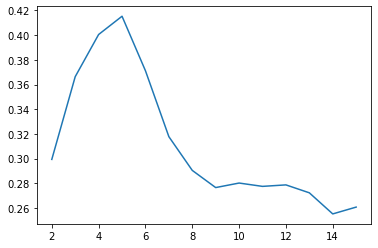

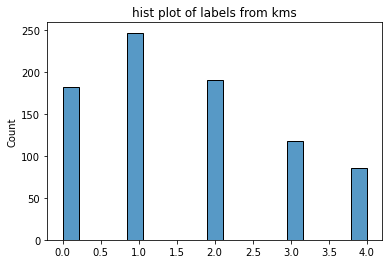

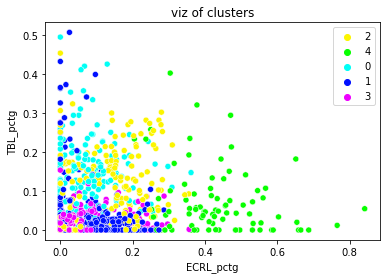

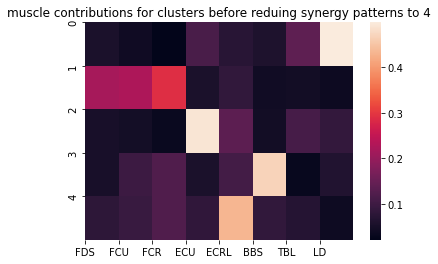

In [1]:
# Chapter 1
## Section 1-1: kNN to label synergies for all hc
# imports
import os
import mne
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk  # to dump pca
import statsmodels.api as sm
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.datasets import fetch_fsaverage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from scipy.signal import hilbert
from scipy.stats import pearsonr
from statsmodels.tsa.api import ARDL
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.tsa.ardl import ardl_select_order
from pygam import GammaGAM, LinearGAM, s
from sklearn.mixture import GaussianMixture
from collections import Counter
from numpy.lib.stride_tricks import sliding_window_view
import pingouin as pg
from sklearn.neighbors import DistanceMetric
from collections import Counter
# %matplotlib qt

# paths and dir
data_dir = os.path.expanduser("/Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke")
max_n_clusters = 16
min_n_clusters = 2
n_emg_chs = 8
trial = 'motor'  # we can later expand it into a loop
outlier_label = 10
    
# read synergy
synergies2df = {'FDS_pctg':[], 'FCU_pctg':[], 'FCR_pctg':[], 'ECU_pctg':[], 'ECRL_pctg':[], 'BBS_pctg':[], 'TBL_pctg':[], 'LD_pctg':[], 'subj_idx':[], 'week':[],
                'trial':[], 'epoch':[], 'synergy_id':[]}
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # loop for healthy people
    synergy_fName = os.path.join(data_dir,'subj'+ subj_idx,'synergy', 'subj' + subj_idx + '_rctg_synergy.csv')
    df_synergy_1session = pd.read_csv(synergy_fName, index_col=0)
    df_synergy_1session_motor = df_synergy_1session[df_synergy_1session['trial']=='motor']
    for index, row in df_synergy_1session_motor.iterrows():
        for n_synergy in np.arange(1,5):
            corrected_muscle_pctg = []
            for muscle_pctg in row['synergy_' + str(n_synergy)].split(' '):
                if '[' in muscle_pctg:
                    corrected_muscle_pctg.append(muscle_pctg[1:])
                elif ']' in muscle_pctg:
                    if muscle_pctg[:-1] == '':
                        pass
                    else:
                        corrected_muscle_pctg.append(muscle_pctg[:-1])
                elif '\n' in muscle_pctg:
                    corrected_muscle_pctg.append(muscle_pctg[:-2])
                elif muscle_pctg == '':
                    pass
                else:
                    corrected_muscle_pctg.append(muscle_pctg)
            corrected_muscle_pctg_norm = np.divide(np.array(corrected_muscle_pctg).astype(float),np.array(corrected_muscle_pctg).astype(float).sum())
            for n_muscle in range(n_emg_chs):
                synergies2df[list(synergies2df.keys())[n_muscle]].append(corrected_muscle_pctg_norm[n_muscle])
            # for n_muscle in range(n_emg_chs):
            #     synergies2df[list(synergies2df.keys())[n_muscle]].append(np.round(float(corrected_muscle_pctg[n_muscle]), 3))
            synergies2df['subj_idx'].append(subj_idx)
            synergies2df['week'].append(0)
            synergies2df['trial'].append(row['trial'])
            synergies2df['epoch'].append(row['epoch'])
            synergies2df['synergy_id'].append(n_synergy)

df_synergy = pd.DataFrame(synergies2df)


# k means (it performs better than gm)
sil = []
for n_clusters in np.arange(min_n_clusters, max_n_clusters):
    kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
    labels = kms.labels_
    sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
plt.plot(np.arange(min_n_clusters, max_n_clusters), sil)
optimal_k = sil.index(np.max(sil)) + min_n_clusters
# optimal_k = 7
kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
labels = kms.labels_
# df_synergy['label'] = labels
# df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
plt.figure()
sns.histplot(labels)
plt.title('hist plot of labels from kms')


# Method 1: set threshold and code artifactual synergy as 99
# for now, we classify artifactual synergy based on the number of the types
# we can also classifiy artifactual synergies based on their distance to the center
# n_threshold = len(labels) * 0.15
# artifact_code = 99
# counts  = Counter(labels)
# labels2recode = []
# clusters_center= []
# labels_thresholded = labels
# for synergy_label in counts.keys():
#     if counts[synergy_label] < n_threshold:
#         labels2recode.append(synergy_label)
#         labels_thresholded[labels_thresholded == synergy_label] = artifact_code
#     else:  # if the number of synergies of a kind passes the threshold, then this kind (cluster center) is saved
#         clusters_center.append(kms.cluster_centers_[synergy_label])
# df_synergy['label'] = labels_thresholded
        
# Method 2: label '99' based on the distance
# distances = []
# quantile = 0.9
# dist = DistanceMetric.get_metric('euclidean')
# X = df_synergy.iloc[:, :n_emg_chs]
# for i in range(len(labels)):
#     distances.append(dist.pairwise([X.iloc[i,:], clusters_center[labels[i]]])[0,1])
# distance_threshold = np.quantile(distances, quantile)
# for i in range(len(distances)):
#     if distances[i] > distance_threshold:
#         labels[i] = 99
# df_synergy['label'] = labels
# print(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))

# Method 3: reduce synergies to 4 according to their occurance
# label_values = np.array(list(Counter(labels).values()))
# label_keys2keep = np.argsort(label_values)[:4]
# for i in range(len(labels)):
#     if labels[i] not in label_keys2keep:
#         labels[i] = outlier_label
# clusters_center = []
# for label in label_keys2keep:
#     clusters_center.append(kms.cluster_centers_[label])
# print(label_keys2keep)
# df_synergy['label'] = labels
# df_synergy_threshold = df_synergy[df_synergy['label'] != outlier_label]
# print(silhouette_score(df_synergy_threshold.iloc[:, :n_emg_chs], df_synergy_threshold['label'], metric = 'euclidean'))  

df_synergy['label'] = labels
df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'hc_labeled_synergies.csv'))
plt.figure()
sns.scatterplot(df_synergy.iloc[:, 4],df_synergy.iloc[:, 6], hue=labels.astype(str), palette='hsv')
plt.title('viz of clusters')
plt.figure()
sns.heatmap(kms.cluster_centers_)
plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
plt.yticks(ticks=np.arange(5), labels=np.arange(optimal_k))
plt.title('muscle contributions for clusters before reduing synergy patterns to 4')
centers_hc = kms.cluster_centers_
# plt.figure()
# sns.heatmap(clusters_center)
# plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
# plt.yticks(ticks=np.arange(4), labels=label_keys2keep)
# plt.title('muscle contributions for clusters')
# viz cluster center

# additional scripts
# compare k_means and GM with k means init
# sil = []
# for n_clusters in np.arange(3, max_n_clusters):
#     kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
#     labels = kms.labels_
#     sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
# plt.plot(np.arange(3, max_n_clusters), sil)
# optimal_k = sil.index(np.max(sil)) + 3
# kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
# labels = kms.labels_
# plt.figure()
# sns.scatterplot(df_synergy.iloc[:, 0],df_synergy.iloc[:, 1], hue=labels, palette='hsv')
# plt.figure()
# sns.histplot(labels)

# sil = []
# for n_clusters in np.arange(3, max_n_clusters):
#     gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
#     labels = gm.predict(df_synergy.iloc[:, :n_emg_chs])
#     sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels))
# plt.figure()
# plt.plot(np.arange(3, max_n_clusters), sil)
# optimal_k = sil.index(np.max(sil)) + 3
# # optimal_k = 4
# gm = GaussianMixture(n_components=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
# labels = gm.predict(df_synergy.iloc[:, :n_emg_chs])
# # df_synergy['label'] = labels
# # df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
# plt.figure()
# sns.scatterplot(df_synergy.iloc[:, 0],df_synergy.iloc[:, 1], hue=labels, palette='hsv')



Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj65/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj66/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No b

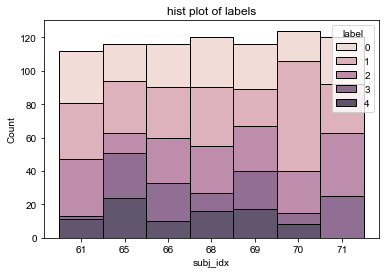

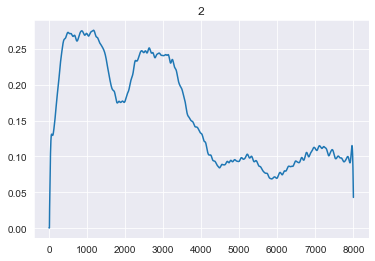

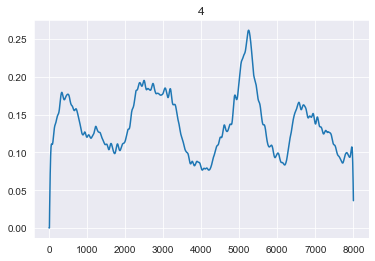

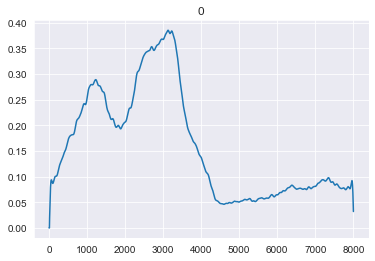

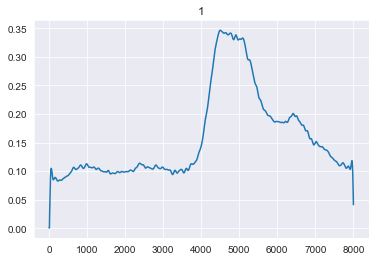

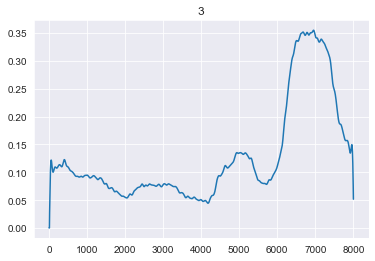

In [2]:
# activation
plt.figure()
sns.histplot(data=df_synergy, x='subj_idx', hue='label', multiple='stack')
plt.title('hist plot of labels')
for i in pd.unique(labels):
    exec('act_synergy_' + str(i) + '= []')
# act_synergy_10 = []

# averaged activation
for subj_idx in pd.unique(df_synergy['subj_idx']): 
    prep_epochs_dir = os.path.join(data_dir,'subj'+ str(subj_idx), 'prep_epochs')
    epochs_prep = mne.read_epochs(os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif'))
    for epoch in pd.unique(df_synergy[df_synergy['subj_idx'] == subj_idx]['epoch']):
        for synergy_id in range(4):
            label = df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['epoch'] == epoch) & (df_synergy['synergy_id'] == (synergy_id + 1))]['label'].values[0]
            exec('act_synergy_' + str(label) + '.append(epochs_prep.copy().pick("emg").get_data()[epoch][synergy_id])')
for synergy_label in pd.unique(labels):
    plt.figure()
    sns.set_style("darkgrid")
    exec('plt.plot(np.mean(act_synergy_' + str(synergy_label) + ',axis=0))')
    plt.title(str(synergy_label))
# plt.show()

## individual patients kmeans

2 implement: save cs matrix

| subj | k_mean_label | remapped_label | cs_hc0 | ... | cs_hc4 |
| ---- | ---------- | ----------- | ------- | ---- | -------- |

/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


42
{0: 4, 1: 'a0', 2: 'a1', 3: 2, 4: 0, 5: 'a2', 6: 2, 7: 'a3', 8: 3}


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


64
{0: 3, 1: 1, 2: 4, 3: 1, 4: 0, 5: 'a0', 6: 2, 7: 'a1'}


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


67
{0: 0, 1: 1, 2: 2, 3: 1, 4: 3, 5: 4}


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


72
{0: 3, 1: 2, 2: 1, 3: 4, 4: 'a0', 5: 0, 6: 1}


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


74
{0: 1, 1: 2, 2: 3, 3: 'a0', 4: 'a1', 5: 4, 6: 0}


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


63
{0: 4, 1: 0, 2: 'a0', 3: 1, 4: 2, 5: 3, 6: 'a1'}


/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_42453/1622099562.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


60
{0: 1, 1: 2, 2: 4, 3: 3, 4: 'a0', 5: 'a1', 6: 0}


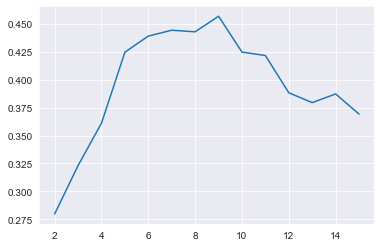

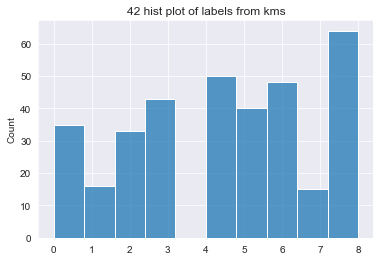

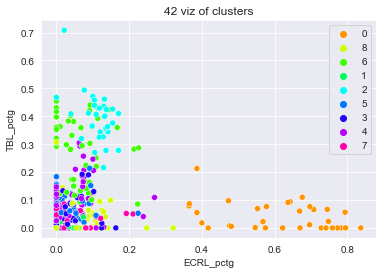

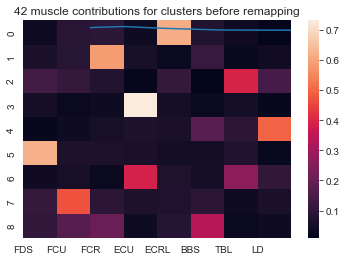

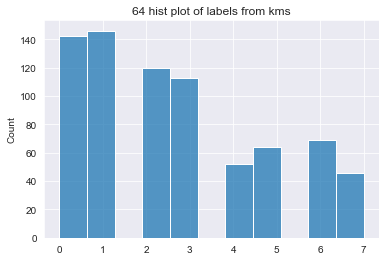

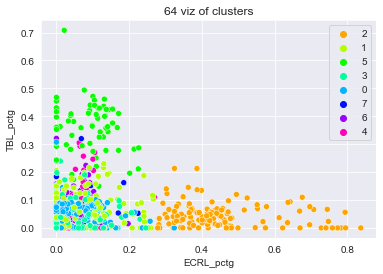

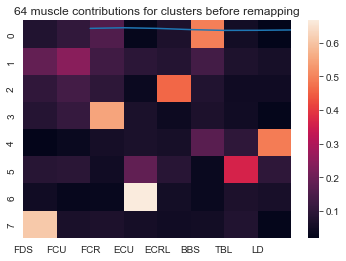

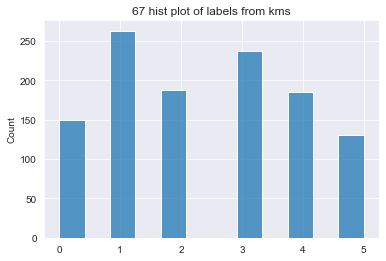

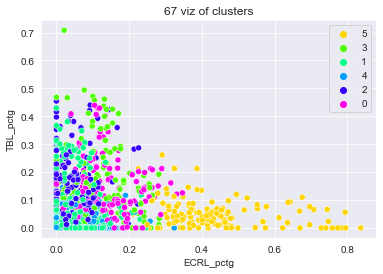

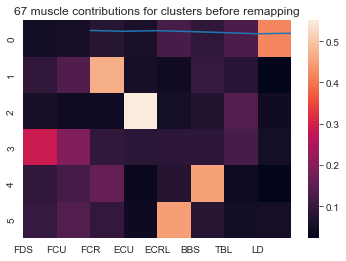

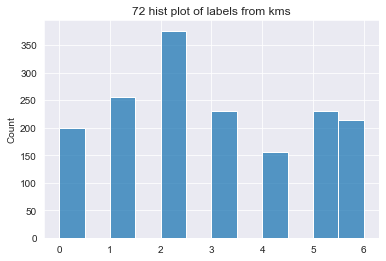

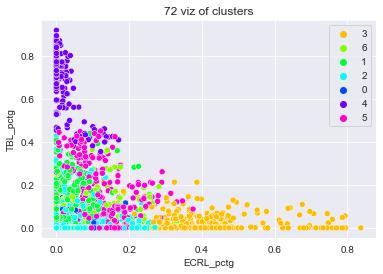

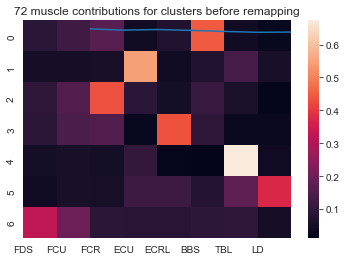

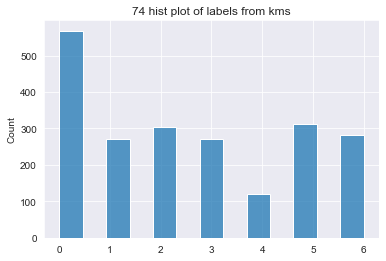

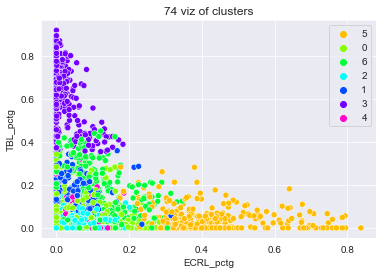

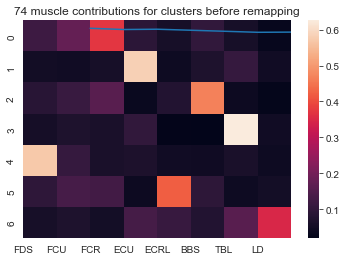

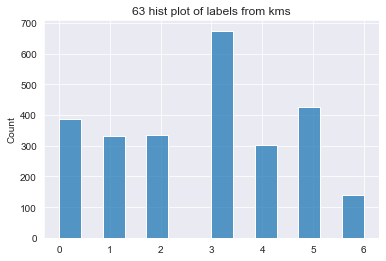

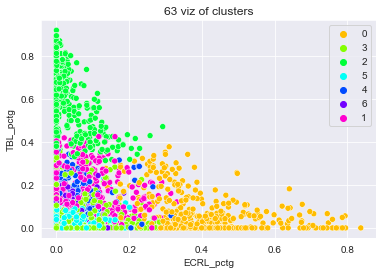

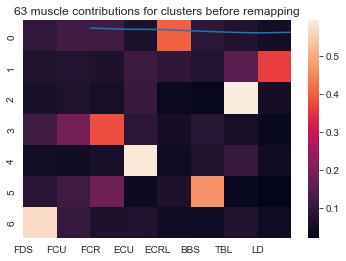

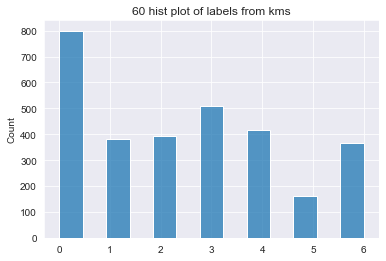

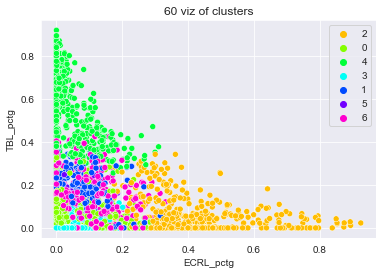

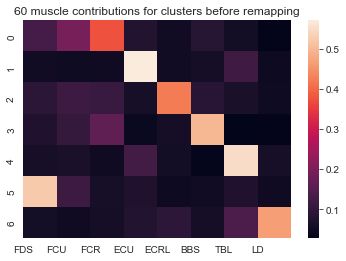

In [3]:
# Chapter 1
## Section 1-3: kNN to label synergies for indivudal patient
from scipy import spatial
# %matplotlib qt
# paths and dir
data_dir = os.path.expanduser("/Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke")
max_n_clusters = 16
min_n_clusters = 2
n_emg_chs = 8
trial = 'motor'  # we can later expand it into a loop
    
# read synergy
synergies2df = {'FDS_pctg':[], 'FCU_pctg':[], 'FCR_pctg':[], 'ECU_pctg':[], 'ECRL_pctg':[], 'BBS_pctg':[], 'TBL_pctg':[], 'LD_pctg':[], 'subj_idx':[], 'week':[],
                'trial':[], 'epoch':[], 'synergy_id':[]}
cs2df = {'subj_idx':[], 'k_mean_label':[], 'remapped_label':[]}
for i in range(5):
    cs2df['cs_hc' + str(i)] = []

from scipy import spatial
# use cosine similarity to recode
df2concatenate = []
for subj_idx in ['42','64','67','72','74','63','60']:  # loop for patients, 63 (1Hz TMS), 60 (10Hz TMS)
    for week in range(4):
        synergy_fName = os.path.join(data_dir,'subj'+ subj_idx,'synergy', 'subj' + subj_idx + '_rctg_synergy.csv')
        df_synergy = pd.read_csv(synergy_fName, index_col=0)
        df_synergy_1week_motor = df_synergy[(df_synergy['trial']=='motor') & (df_synergy['week']==week)]
        for index, row in df_synergy_1week_motor.iterrows():
            for n_synergy in np.arange(1,5):
                corrected_muscle_pctg = []
                for muscle_pctg in row['synergy_' + str(n_synergy)].split(' '):
                    if muscle_pctg == '':
                        pass
                    elif '[' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[1:])
                    elif ']' in muscle_pctg:
                        if muscle_pctg[:-1] == '':
                            pass
                        else:
                            corrected_muscle_pctg.append(muscle_pctg[:-1])
                        
                    elif '\n' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[:-2])
                    else:
                        corrected_muscle_pctg.append(muscle_pctg)
                corrected_muscle_pctg_norm = np.divide(np.array(corrected_muscle_pctg).astype(float),np.array(corrected_muscle_pctg).astype(float).sum())
                for n_muscle in range(n_emg_chs):
                    synergies2df[list(synergies2df.keys())[n_muscle]].append(corrected_muscle_pctg_norm[n_muscle])
                synergies2df['subj_idx'].append(subj_idx)
                synergies2df['week'].append(week)
                synergies2df['trial'].append(row['trial'])
                synergies2df['epoch'].append(row['epoch'])
                synergies2df['synergy_id'].append(n_synergy)

    df_synergy = pd.DataFrame(synergies2df)
    # k means (it performs better than gm)
    sil = []
    for n_clusters in np.arange(min_n_clusters, max_n_clusters):
        kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
        labels = kms.labels_
        sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
    plt.plot(np.arange(min_n_clusters, max_n_clusters), sil)
    optimal_k = sil.index(np.max(sil)) + min_n_clusters
    # optimal_k = 7
    kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
    labels = kms.labels_

# Method 1: set threshold and code artifactual synergy as 99
# for now, we classify artifactual synergy based on the number of the types
# we can also classifiy artifactual synergies based on their distance to the center
# n_threshold = len(labels) * 0.1
# artifact_code = 10
# counts  = Counter(labels)
# labels2recode = []
# clusters_center= []
# labels_thresholded = labels
# for synergy_label in counts.keys():
#     if counts[synergy_label] < n_threshold:
#         labels2recode.append(synergy_label)
#         labels_thresholded[labels_thresholded == synergy_label] = artifact_code
#     else:  # if the number of synergies of a kind passes the threshold, then this kind (cluster center) is saved
#         clusters_center.append(kms.cluster_centers_[synergy_label])
# df_synergy['label'] = labels_thresholded

    cosine_similarity_thres = 0.8
    centers1patient = kms.cluster_centers_
    cs_matrix = np.zeros([len(centers1patient), len(centers_hc)])  # n_patient_label * n_hc_label
    relabel_map = {}  # pc_label:hc_label
    for i in range(len(centers1patient)):
        for j in range(len(centers_hc)):
            cs_matrix[i][j] = 1 - spatial.distance.cosine(centers1patient[i], centers_hc[j])
    # complete relabel_map to remap 
    n_abnormal_synergy = 0
    for i in range(len(centers1patient)):
        if np.max(cs_matrix[i]) < cosine_similarity_thres:
            relabel_map[i] = 'a' + str(n_abnormal_synergy)
            n_abnormal_synergy += 1
        else:
            relabel_map[i] = np.argmax(cs_matrix[i])
        cs2df['subj_idx'].append(subj_idx)
        cs2df['k_mean_label'].append(i)
        cs2df['remapped_label'].append(relabel_map[i])
        for j in range(5):
            cs2df['cs_hc' + str(j)].append(cs_matrix[i][j])
    # start remapping
    labels_remapped = list(map(lambda label: relabel_map[label], labels))
    df_synergy['label'] = labels_remapped
    df2concatenate.append(df_synergy)
    plt.figure()
    sns.histplot(labels)
    plt.title(subj_idx + ' hist plot of labels from kms')
    # df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
    plt.figure()
    sns.scatterplot(df_synergy.iloc[:, 4],df_synergy.iloc[:, 6], hue=labels.astype(str), palette='hsv')
    plt.title(subj_idx + ' viz of clusters')
    plt.figure()
    sns.heatmap(kms.cluster_centers_)
    plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
    # plt.yticks(ticks=np.arange(optimal_k), labels=pd.unique(labels))
    plt.title(subj_idx + ' muscle contributions for clusters before remapping')
    print(subj_idx)
    print(relabel_map)
df_synergy_patients = pd.concat(df2concatenate)
df_synergy_patients.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies_patients.csv'))
df_cs = pd.DataFrame(cs2df)
df_cs.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'cs_patients.csv'))

## visualize synergy distribution and activation curves (separately for each patient)

In [4]:
%matplotlib qt
# individual sta for patients
plt.figure()
sns.histplot(data=df_synergy, x='subj_idx', hue='label', multiple='stack')
plt.title('hist plot of labels')

# act_synergy_10 = []

# averaged activation
for subj_idx in pd.unique(df_synergy['subj_idx']): 
# for subj_idx in ['42']:
    for i in pd.unique(df_synergy[df_synergy['subj_idx'] == subj_idx]['label']):
        exec('act_synergy_' + str(i) + '= []')
    prep_epochs_dir = os.path.join(data_dir,'subj'+ str(subj_idx), 'prep_epochs')
    for week in range(4):
        epochs_prep = mne.read_epochs(os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif'))
        for epoch in pd.unique(df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['week'] == week)]['epoch']):
            for synergy_id in range(4):
                label = df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['epoch'] == epoch) & (df_synergy['synergy_id'] == (synergy_id + 1))&
                                   (df_synergy['week'] == week)]['label'].values[0]
                exec('act_synergy_' + str(label) + '.append(epochs_prep.copy().pick("emg").get_data()[epoch][synergy_id])')
    for synergy_label in pd.unique(df_synergy[df_synergy['subj_idx'] == subj_idx]['label']):
        plt.figure()
        sns.set_style("darkgrid")
        plt.title(subj_idx + 'synergy_' + str(synergy_label))
        exec('plt.plot(np.mean(act_synergy_' + str(synergy_label) + ',axis=0))')
plt.legend()
# plt.show()

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week0_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week1_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week2_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
16 matching

/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_42453/1371698211.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj72/prep_epochs/motor_week0_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj72/prep_epochs/motor_week1_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj72/prep_epochs/motor_week2_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
31 matching

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## plot activation for a specific synergy for all patients

In [5]:
%matplotlib qt
for label in range(5):
    exec('fig_' + str(label) + ', axis_' + str(label) + '= plt.subplots(1, 1)')
sns.set_style("darkgrid")

for subj_idx in pd.unique(df_synergy['subj_idx']): 
# for subj_idx in [42]: 
    for i in pd.unique(df_synergy[df_synergy['subj_idx'] == subj_idx]['label']):
        exec('act_synergy_' + str(i) + '= []')
    prep_epochs_dir = os.path.join(data_dir,'subj'+ str(subj_idx), 'prep_epochs')
    for week in range(4):
        epochs_prep = mne.read_epochs(os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif'))
        for epoch in pd.unique(df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['week'] == week)]['epoch']):
            for synergy_id in range(4):
                label = df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['epoch'] == epoch) & (df_synergy['synergy_id'] == (synergy_id + 1))&
                                   (df_synergy['week'] == week)]['label'].values[0]
                exec('act_synergy_' + str(label) + '.append(epochs_prep.copy().pick("emg").get_data()[epoch][synergy_id])')
    # for synergy_label in pd.unique(df_synergy[df_synergy['subj_idx'] == subj_idx]['label']):
        
    
    for label in range(5):
        exec('axis_' + str(label) + '.plot(np.mean(act_synergy_' + str(label) +', axis=0), label=subj_idx)')
        exec('axis_' + str(label) + '.set_title("all_patients_synergy_" + str(label))')
        exec('axis_' + str(label) + '.legend()')
# plt.show()

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week0_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week1_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week2_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
16 matching

# Chapter 2: linear regression
we first perform time-frequency analysis, find the temporal dynamic of oscillatory power (determined by fooof) for each ch. 
Then we correlate the pca of power time series and the moving average of synergy

In [6]:
## Section 3-1 retrieve oscillatory power across time for EEG signals
## output matrix: Mf n_epoch * n_ch * time
# parameters
cutoff_margin = 1
trial = 'motor'
n_eeg_chs = 32
fs_eeg = 500
n_fft = 256
noverlap=128
n_samples_spec = int(8001 // (n_fft - noverlap) - 1)  # 8001 is the number of sample points, 1s = 1000ms
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
# for subj_idx in ['61']:
# read epochs
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    if not os.path.exists(csc_dir):
        os.makedirs(csc_dir)
    prep_report_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_report')
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    fooof_fName = os.path.join(prep_report_dir, 'subj' + subj_idx + '_rctg_fooof.csv')
    epochs_prep = mne.read_epochs(epochs_fName)
    epochs = epochs_prep.copy()
    fooof = pd.read_csv(fooof_fName, index_col=0)
    Mf = []
    for n_epoch in range(epochs.get_data().shape[0]):
        # read psd peaks
        Mf_1epoch = []
        for ch_name in epochs.ch_names[:n_eeg_chs]:
            fooof_1ch = fooof[(fooof['ch']==ch_name) & (fooof['trial']==trial)]  # integrate fooof from all the epochs
            if fooof_1ch.shape[0] == 0:  # no peaks were detected
                Mf_1epoch.append(np.zeros(n_samples_spec))
            else:
                lf_cutoff = np.max([0, (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] -\
                fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] - cutoff_margin).values[0]])
                hf_cutoff = (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] +\
                fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] + cutoff_margin).values[0]
                
                eeg_data = epochs.copy().pick(ch_name).get_data()[n_epoch, 0, :]
                powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(eeg_data, Fs=fs_eeg)
                powerS2sum = []
                for n_freq in range(len(freqenciesFound)):
                    if (freqenciesFound[n_freq] > lf_cutoff) & (freqenciesFound[n_freq] < hf_cutoff):
                        powerS2sum.append(powerSpectrum[n_freq,:])
                Mf_1epoch.append(np.sum(powerS2sum, axis=0).tolist())
        Mf.append(np.array(Mf_1epoch))
        Mf_2D = np.array(Mf).reshape(np.array(Mf).shape[0], -1)
        np.savetxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_Mf_p.csv'), Mf_2D)

ç
# read epochs
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    if not os.path.exists(csc_dir):
        os.makedirs(csc_dir)
    prep_report_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_report')
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    for week in range(4):
        epochs_fName = os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif')
        fooof_fName = os.path.join(prep_report_dir, 'subj' + subj_idx + '_rctg_fooof.csv')
        epochs_prep = mne.read_epochs(epochs_fName)
        epochs = epochs_prep.copy()
        fooof = pd.read_csv(fooof_fName, index_col=0)
        Mf = []
        for n_epoch in range(epochs.get_data().shape[0]):
            # read psd peaks
            Mf_1epoch = []
            for ch_name in epochs.ch_names[:n_eeg_chs]:
                fooof_1ch = fooof[(fooof['ch']==ch_name) & (fooof['trial']==trial) & (fooof['week']==week)]
                if fooof_1ch.shape[0] == 0:  # no peaks were detected
                    Mf_1epoch.append(np.zeros(n_samples_spec))
                else:
                    lf_cutoff = np.max([0, (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] -\
                    fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] - cutoff_margin).values[0]])
                    hf_cutoff = (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] +\
                    fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] + cutoff_margin).values[0]

                    eeg_data = epochs.copy().pick(ch_name).get_data()[n_epoch, 0, :]
                    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(eeg_data, Fs=fs_eeg)
                    powerS2sum = []
                    for n_freq in range(len(freqenciesFound)):
                        if (freqenciesFound[n_freq] > lf_cutoff) & (freqenciesFound[n_freq] < hf_cutoff):
                            powerS2sum.append(powerSpectrum[n_freq,:])
                    Mf_1epoch.append(np.sum(powerS2sum, axis=0).tolist())
            Mf.append(np.array(Mf_1epoch))
            Mf_2D = np.array(Mf).reshape(np.array(Mf).shape[0], -1)
            np.savetxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_week' + str(week) + '_Mf_p.csv'), Mf_2D)

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj65/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj66/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No b

In [7]:
## Section 2-2 model the synergy based on specogram, one sample linear regression
# pca inversion passed the test, the order of chs is correct
from random import random, seed, shuffle
seed(99)
# fc to calculate z score
def z_srg(x, srg):
    '''
    x: float, value
    srg: array-like, std data
    '''
    if np.nonzero(srg)[0].shape[0] > 0: 
        return (x - np.mean(srg)) / np.std(srg)
    else:
        return 0

# parameters   
n_eeg_chs = 32
n_srg = 50
# reseting    
plt.close()
plt.clf()
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# read synergies info
df_synergy_hc = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'hc_labeled_synergies.csv'), index_col=0)
df_synergy_patients = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies_patients.csv'), index_col=0)
df_synergy = pd.concat([df_synergy_hc, df_synergy_patients])

# retrieve epochs info
prep_epochs_dir = os.path.join(data_dir, 'subj61', 'prep_epochs')  # use 61 as an example
epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
epochs_prep = mne.read_epochs(epochs_fName)
reg_res2df = {'subj': [],
              'week': [],
              'trial': [],
              'epoch': [],
              'synergy_label': [],
              'explained_v':[],
              'explained_v_z':[],}
for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    reg_res2df[ch] = []
    reg_res2df[ch + '_z'] = []  # z-scored
    
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
# for subj_idx in []:  # for testing
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    # pca_dir = os.path.join(csc_dir, 'pca')
    # if not os.path.exists(pca_dir):
    #     os.makedirs(pca_dir)
    Mf_2D = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_Mf_p.csv'))
    Mf = Mf_2D.reshape(Mf_2D.shape[0], n_eeg_chs, Mf_2D.shape[1] // n_eeg_chs)

    # get synergies
    prep_epochs_dir = os.path.join(data_dir, 'subj' + subj_idx, 'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    epochs_prep = mne.read_epochs(epochs_fName)
    synergies = epochs_prep.copy().pick(['emg']).get_data()

    for n_epoch in range(Mf.shape[0]):
    # for n_epoch in range(2):  # for test
        print('epoch ' + str(n_epoch))
        Mf_1epoch = Mf[n_epoch]  # some chs can be 0 because no peek was detected
        synergies_1epoch = synergies[n_epoch]
        pca=PCA(n_components=0.95, random_state=97)  
        Tf_1epoch = pca.fit_transform(Mf_1epoch.T)  # avoid collinearity
        number_pca_components = pca.components_.shape[0]
        for n_synergy in range(synergies_1epoch.shape[0]):
            synergy_label = df_synergy[(df_synergy['subj_idx'] == int(subj_idx)) & (df_synergy['week'] == 0) & (df_synergy['trial']== 'motor') &
                                       (df_synergy['epoch'] == n_epoch) & (df_synergy['synergy_id']==n_synergy + 1)]['label'].values[0]
            synergy_window = sliding_window_view(synergies_1epoch[n_synergy], window_shape = n_fft)
            synergy_ma = []
            for i in range(Tf_1epoch.shape[0]):
                synergy_ma.append(synergy_window[int(noverlap * i - 1)].mean())
            # normalize pca components to make sure t statistics are correct
            Tf_1epoch_n =  Tf_1epoch * np.mean(synergy_ma) / np.abs(Tf_1epoch).mean()
            pg_res = pg.linear_regression(Tf_1epoch_n,synergy_ma)
            
            # construct ch spaces coherence
            # construct coherence matrix in pca domain
            r2 = pg_res.r2.values[0]
            csc_pca_domain = pg_res['T'][1:].values
            csc_ch_domain = pca.inverse_transform(csc_pca_domain)
            reg_res2df['subj'].append(subj_idx)
            reg_res2df['week'].append(0)
            reg_res2df['trial'].append('motor')
            reg_res2df['epoch'].append(n_epoch)
            reg_res2df['synergy_label'].append(synergy_label)
            reg_res2df['explained_v'].append(r2)  # if we decide to not include y(t-1)
            for n_ch in range(n_eeg_chs):
                reg_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch]].append(np.abs(csc_ch_domain[n_ch]))  # csc represents coherence (>0)
                
            # srg testing
            synergy_srg = synergy_ma.copy()
            csc_ch_domain_srg_list = [] 
            r2_srg_list = []
            for i in range(n_srg):
                shuffle(synergy_srg)
                pg_res = pg.linear_regression(Tf_1epoch_n, synergy_srg)
                csc_pca_domain_srg = pg_res['T'][1:].values
                csc_ch_domain_srg = pca.inverse_transform(csc_pca_domain_srg)
                csc_ch_domain_srg_list.append(np.abs(csc_ch_domain_srg))
                r2_srg_list.append(pg_res.r2.values[0])
            csc_ch_domain_dist = np.vstack(csc_ch_domain_srg_list)
            for n_ch in range(n_eeg_chs):
                reg_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch] + '_z'].append(z_srg(np.abs(csc_ch_domain[n_ch]), 
                                                                                                      csc_ch_domain_dist[:, n_ch]))  # csc represents coherence (>0)
            reg_res2df['explained_v_z'].append(z_srg(r2, r2_srg_list))

for subj_idx in ['42','64','67','72','74','63','60']:  # loop for patients, 63 (1Hz TMS), 60 (10Hz TMS)
    prep_epochs_dir = os.path.join(data_dir, 'subj' + subj_idx, 'prep_epochs')
    csc_dir = os.path.join(data_dir,'subj' + subj_idx,'csc')
    for week in range(4):
        Mf_2D = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_week' + str(week) + '_Mf_p.csv'))
        Mf = Mf_2D.reshape(Mf_2D.shape[0], n_eeg_chs, Mf_2D.shape[1] // n_eeg_chs)

        # get synergies
        
        epochs_fName = os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif')
        epochs_prep = mne.read_epochs(epochs_fName)
        synergies = epochs_prep.copy().pick(['emg']).get_data()

        for n_epoch in range(Mf.shape[0]):
        # for n_epoch in range(2):  # for test
            print('epoch ' + str(n_epoch))
            Mf_1epoch = Mf[n_epoch]  # some chs can be 0 because no peek was detected
            synergies_1epoch = synergies[n_epoch]
            pca = PCA(n_components=0.95, random_state=97)  
            Tf_1epoch = pca.fit_transform(Mf_1epoch.T)  # avoid collinearity
            number_pca_components = pca.components_.shape[0]
            for n_synergy in range(synergies_1epoch.shape[0]):
                synergy_label = df_synergy[(df_synergy['subj_idx'] == int(subj_idx)) & (df_synergy['week'] == week) & (df_synergy['trial']== 'motor') &
                                           (df_synergy['epoch'] == n_epoch) & (df_synergy['synergy_id']==n_synergy + 1)]['label'].values[0]
                synergy_window = sliding_window_view(synergies_1epoch[n_synergy], window_shape = n_fft)
                synergy_ma = []
                for i in range(Tf_1epoch.shape[0]):
                    synergy_ma.append(synergy_window[int(noverlap * i - 1)].mean())
                # normalize pca components to make sure t statistics are correct
                Tf_1epoch_n =  Tf_1epoch * np.mean(synergy_ma) / np.abs(Tf_1epoch).mean()
                pg_res = pg.linear_regression(Tf_1epoch_n,synergy_ma)

                # construct ch spaces coherence
                # construct coherence matrix in pca domain
                r2 = pg_res.r2.values[0]
                csc_pca_domain = pg_res['T'][1:].values
                csc_ch_domain = pca.inverse_transform(csc_pca_domain)
                reg_res2df['subj'].append(subj_idx)
                reg_res2df['week'].append(week)
                reg_res2df['trial'].append('motor')
                reg_res2df['epoch'].append(n_epoch)
                reg_res2df['synergy_label'].append(synergy_label)
                reg_res2df['explained_v'].append(r2)  # if we decide to not include y(t-1)
                for n_ch in range(n_eeg_chs):
                    reg_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch]].append(np.abs(csc_ch_domain[n_ch]))  # csc represents coherence (>0)

                # srg testing
                synergy_srg = synergy_ma.copy()
                csc_ch_domain_srg_list = [] 
                r2_srg_list = []
                for i in range(n_srg):
                    shuffle(synergy_srg)
                    pg_res = pg.linear_regression(Tf_1epoch_n, synergy_srg)
                    csc_pca_domain_srg = pg_res['T'][1:].values
                    csc_ch_domain_srg = pca.inverse_transform(csc_pca_domain_srg)
                    csc_ch_domain_srg_list.append(np.abs(csc_ch_domain_srg))
                    r2_srg_list.append(pg_res.r2.values[0])
                csc_ch_domain_dist = np.vstack(csc_ch_domain_srg_list)
                for n_ch in range(n_eeg_chs):
                    reg_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch] + '_z'].append(z_srg(np.abs(csc_ch_domain[n_ch]), 
                                                                                                          csc_ch_domain_dist[:, n_ch]))  # csc represents coherence (>0)
                reg_res2df['explained_v_z'].append(z_srg(r2, r2_srg_list))



df_reg_res = pd.DataFrame(reg_res2df)
df_reg_res.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'csc_ch_domain_current.csv'))

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_

In [8]:
## Section 2-3 viz topological distribution of csc in the scalp 
# with more epochs, we should average the csc for each ch over each synergy

# This is done before viz
# use surrogate testing to extract significant ch and viz again
# we create surrogate data by selecting a segment at the begining from the synergy, then mutating it with a segment at the end with same synergy onset and offset.
# then repeat the ardl modeling
ch_z2plot = []
for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    ch_z2plot.append(ch + '_z')
    # ch_z2plot.append(ch)
df_reg_res = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'csc_ch_domain_current.csv'), index_col=0)
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
# for subj_idx in ['68']:  # healthy controls
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    epochs_prep = mne.read_epochs(epochs_fName)
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    scalp_dist_dir = os.path.join(csc_dir, 'scalp_dist')
    if not os.path.exists(scalp_dist_dir):
        os.makedirs(scalp_dist_dir)
    df_reg_res_1subj = df_reg_res[df_reg_res['subj']==int(subj_idx)]
    
    # uncomment to see individual topo plot of each epoch
#     for _,row in df_ardl_res.iterrows():
#         subj_idx = row['subj']
#         week = row['week']
#         epoch = row['epoch']
#         synergy_label = row['synergy_label']
#         fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
#                            sharex=True, sharey=True)
#         mne.viz.plot_topomap(row[epochs_prep.copy().pick('eeg').info['ch_names']], epochs_prep.info, axes=ax, show=False)
#         ax.set_title(str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label))
#         plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '.eps'))

#         ch_z2plot = []
#         for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
#             ch_z2plot.append(ch + '_z')
#         fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
#                            sharex=True, sharey=True)
#         mne.viz.plot_topomap(row[ch_z2plot], epochs_prep.info, axes=ax, show=False)
#         ax.set_title(str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '_zCSC')
#         plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '_zCSC.eps'))
        
#         plt.clf()
#         plt.close()

# averaged over epochs for each synergy-eeg combination
    for n_synergy in pd.unique(df_reg_res['synergy_label']):
        csc_1synergy = df_reg_res_1subj[df_reg_res_1subj['synergy_label'] == n_synergy][epochs_prep.copy().pick('eeg').info['ch_names']].mean(axis=0)
        fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                           sharex=True, sharey=True)
        mne.viz.plot_topomap(csc_1synergy, epochs_prep.info, axes=ax, show=False)
        ax.set_title(str(subj_idx) + '_week0_synergy' + str(n_synergy) + '_avg')
        plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week0_synergy' + str(n_synergy) + '_avg.eps'))
        zcsc_1synergy = df_reg_res_1subj[df_reg_res_1subj['synergy_label'] == n_synergy][ch_z2plot].mean(axis=0)
        fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                           sharex=True, sharey=True)
        mne.viz.plot_topomap(zcsc_1synergy, epochs_prep.info, axes=ax, show=False)
        ax.set_title(str(subj_idx) + '_week0_synergy' + str(n_synergy)+ '_avg_z')
        plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week0_synergy' + str(n_synergy) + '_avg_z.eps'))
    # for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    
for subj_idx in ['42','64','67','72','74','63','60']:  # loop for patients, 63 (1Hz TMS), 60 (10Hz TMS)
    # prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    # epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    # epochs_prep = mne.read_epochs(epochs_fName)
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    scalp_dist_dir = os.path.join(csc_dir, 'scalp_dist')
    if not os.path.exists(scalp_dist_dir):
        os.makedirs(scalp_dist_dir)
    df_reg_res_1subj = df_reg_res[df_reg_res['subj']==int(subj_idx)]

# averaged over epochs for each synergy-eeg combination
    for week in range(4):
        df_reg_res_1subj_1week = df_reg_res_1subj[df_reg_res_1subj['week']==week]
        for n_synergy in pd.unique(df_reg_res_1subj_1week['synergy_label']):
            csc_1synergy = df_reg_res_1subj_1week[df_reg_res_1subj_1week['synergy_label'] == n_synergy][epochs_prep.copy().pick('eeg').info['ch_names']].mean(axis=0)
            fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                               sharex=True, sharey=True)
            mne.viz.plot_topomap(csc_1synergy, epochs_prep.info, axes=ax, show=False)
            ax.set_title(str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy) + '_avg')
            plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy) + '_avg.eps'))
            zcsc_1synergy = df_reg_res_1subj_1week[df_reg_res_1subj_1week['synergy_label'] == n_synergy][ch_z2plot].mean(axis=0)
            fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                               sharex=True, sharey=True)
            mne.viz.plot_topomap(zcsc_1synergy, epochs_prep.info, axes=ax, show=False)
            ax.set_title(str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy)+ '_avg_z')
            plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy) + '_avg_z.eps'))
    # for ch in epochs_prep.copy().pick('eeg').info['ch_names']:

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj65/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


/var/folders/m5/pxjgb09d7n725qrhktvw5bs80000gp/T/ipykernel_42453/3948535712.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),


Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj66/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj68/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj69/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No b

# Chapter 3: ARDL (put aside for now)

In [675]:
# Chapter 2
## Section 2-1 retrieve information and band pass EEG signals
## output matrix: Mf
# parameters
cutoff_margin = 1
trial = 'motor'
n_eeg_chs = 32
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
# read epochs
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    if not os.path.exists(csc_dir):
        os.makedirs(csc_dir)
    prep_report_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_report')
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    fooof_fName = os.path.join(prep_report_dir, 'subj' + subj_idx + '_rctg_fooof.csv')
    epochs_prep = mne.read_epochs(epochs_fName)
    epochs = epochs_prep.copy()
    fooof = pd.read_csv(fooof_fName, index_col=0)
    Mf = []
    # read psd peaks
    for ch_name in epochs.ch_names[:n_eeg_chs]:
        fooof_1ch = fooof[(fooof['ch']==ch_name) & (fooof['trial']==trial)]
        if fooof_1ch.shape[0] == 0:  # no peaks were detected
            Mf.append(np.zeros([epochs.get_data().shape[0], epochs.get_data().shape[2]]))
        else:
            lf_cutoff = np.max([0, (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] -\
            fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] - cutoff_margin).values[0]])
            hf_cutoff = fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] +\
            fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] + cutoff_margin
            Mf.append(np.squeeze(epochs.copy().filter(lf_cutoff, hf_cutoff, picks=ch_name, method='iir', verbose='WARNING').get_data(picks=ch_name),1))
    Mf = np.swapaxes(Mf, 0,1)  # switch structure to n_epoch * n_ch * time
    # save Mf for PCA inversion
    Mf_2D = np.array(Mf).reshape(np.array(Mf).shape[0], -1)
    np.savetxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_Mf.csv'), Mf_2D)
    
for subj_idx in ['42','64','67','72','74']:  # patients
# read epochs
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    if not os.path.exists(csc_dir):
        os.makedirs(csc_dir)
    prep_report_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_report')
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    for week in range(4):
        epochs_fName = os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif')
        fooof_fName = os.path.join(prep_report_dir, 'subj' + subj_idx + '_rctg_fooof.csv')
        epochs_prep = mne.read_epochs(epochs_fName)
        epochs = epochs_prep.copy()
        fooof = pd.read_csv(fooof_fName, index_col=0)
        Mf = []
        # read psd peaks
        for ch_name in epochs.ch_names[:n_eeg_chs]:
            fooof_1ch = fooof[(fooof['ch']==ch_name) & (fooof['trial']==trial) & (fooof['week']==week)]
            if fooof_1ch.shape[0] == 0:  # no peaks were detected
                Mf.append(np.zeros([epochs.get_data().shape[0], epochs.get_data().shape[2]]))
            else:
                lf_cutoff = np.max([0, (fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] -\
                fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] - cutoff_margin).values[0]])
                hf_cutoff = fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['center_freq'] +\
                fooof_1ch[fooof_1ch['power']==fooof_1ch['power'].max()]['bandwidth'] + cutoff_margin
                Mf.append(np.squeeze(epochs.copy().filter(lf_cutoff, hf_cutoff, picks=ch_name, method='iir', verbose='WARNING').get_data(picks=ch_name),1))
        Mf = np.swapaxes(Mf, 0,1)  # switch structure to n_epoch * n_ch * time
        # save Mf for PCA inversion
        Mf_2D = np.array(Mf).reshape(np.array(Mf).shape[0], -1)
        np.savetxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_week' + str(week) + '_Mf.csv'), Mf_2D)
        
# the script passed test
# print(Mf_2D)
# print(Mf_2D.shape)
# Mf_2D_new = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_week' + str(week) + '_Mf.csv'))
# Mf = Mf_2D_new.reshape(Mf_2D_new.shape[0], n_eeg_chs, Mf_2D_new.shape[1] // n_eeg_chs)
# print(Mf)
# print(Mf.shape)

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj65/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj66/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No b

## ARDL result structure:

| Subj | Session | Trial | epoch | synergy_label | coherence in the ch space | ardl_order |
| ---- | ------- | ----- | ----- | ------------- | ------------------------- | ---------- |
|  61. |    s01  | motor | 0.    |     1         |        info               |    dict    |


coherence is measured with standardized coefficient, coherence of pcs are projected back to ch space
- separate amp-synergy coupling, and phase-synergy coupling (scatter, pearsonr, ev show these variables might be independent), if we choose to apply pac, pac can be seen as amp/phase extraction
- two parameters to be searched: delay (estimated through), number of knots (estimated through aic or other scores)
- another approach, using autoregressive distributed lag model

$$ synergy_t = \beta 0 + \beta 1 synergy_{t-1} + \gamma 0 amp_t + \gamma 1 amp_{t-1}  + \epsilon $$

- Mf: eeg matrix after band-pass filter, n_epoch * n_chs * time
- Hf: amplitude or phase matrix obtained through hilbert trans, n_epoch * n_chs * time
- Tf: component of amplitude/phase matrix, we use pca as a spatial filter, n_comp * n_chs * time

## surrogate generation
For each epoch, we generate n srg sets of csc (one srg with PCA components, then project back to ch space)
the ch_z is the observed csc minus the mean csc_srg over the std

## current result
mostly negative csc, several ways to test:
- when the order is (1,), put 0 csc (meaning no pca contributes to synergy), it still needs to be implemented
- ardl between synergy_differentiation and the hilbert envlope of Tf, we found low explained variance - dead end
- the reason why the model with y order 1 can have high EV is because the predicted y is basically shifted. We can separate the data into train and test, and test ardl with order 1 y on the test dataset

In [94]:
## Section 2-2 ardl to model the synergy
# pca inversion passed the test, the order of chs is correct
from random import random, seed, shuffle
seed(99)
# fc to calculate z score
def z_srg(x, srg):
    '''
    x: float, value
    srg: array-like, std data
    '''
    if np.nonzero(srg)[0].shape[0] > 0: 
        return (x - np.mean(srg)) / np.std(srg)
    else:
        return 0

# parameters   
n_eeg_chs = 32
n_srg = 25
# reseting    
plt.close()
plt.clf()
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# read synergies info
df_synergy_hc = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'hc_labeled_synergies.csv'), index_col=0)
df_synergy_patients = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies_patients.csv'), index_col=0)

# retrieve epochs info
prep_epochs_dir = os.path.join(data_dir,'subj61','prep_epochs')
epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
epochs_prep = mne.read_epochs(epochs_fName)
ardl_res2df = {'subj': [],
               'week': [],
               'trial': [],
               'epoch': [],
               'synergy_label': [],
               'ardl_order': [],
              'aic':[],
              'explained_v':[]}
for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    ardl_res2df[ch] = []
    ardl_res2df[ch + '_z'] = []  # z-scored
    
# for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
for subj_idx in ['61']:  # for testing
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    # pca_dir = os.path.join(csc_dir, 'pca')
    # if not os.path.exists(pca_dir):
    #     os.makedirs(pca_dir)
    Mf_2D = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_Mf.csv'))
    Mf = Mf_2D.reshape(Mf_2D.shape[0], n_eeg_chs, Mf_2D.shape[1] // n_eeg_chs)

    # get synergies
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    epochs_prep = mne.read_epochs(epochs_fName)
    synergies = epochs_prep.copy().pick(['emg']).get_data()

    for n_epoch in range(Mf.shape[0]):
    # for n_epoch in range(2):  # for test
        print('epoch ' + n_epoch)
        Mf_1epoch = Mf[n_epoch]  # some chs can be 0 because no peek was detected
        synergies_1epoch = synergies[n_epoch]
        pca=PCA(n_components=0.95, random_state=97)  
        Tf_1epoch = pca.fit_transform(Mf_1epoch.T)
        Tf_1epoch_analytic = hilbert(Tf_1epoch)
        Tf_1epoch_env = np.abs(Tf_1epoch_analytic)
        # pk.dump(pca, open("subj" + subj_idx + '_' + session_idx + "_motor_pca.pkl", "wb"))
    #     to load pca class
    #     with open('pca.pkl', 'rb') as pickle_file:
    #         pca = pickle.load(pickle_file)

    #     Tf.append(Tf_1epoch.T)

        for n_synergy in range(synergies_1epoch.shape[0]):
            synergy_label = df_synergy[(df_synergy['week'] == 0) & (df_synergy['trial']== 'motor') &
                                       (df_synergy['epoch'] == n_epoch) & (df_synergy['synergy_id']==n_synergy + 1)]['label'].values[0]
            # sel_res = ardl_select_order(synergies_1epoch[n_synergy], 0, Tf_1epoch, 2, ic="aic", trend="c")  # select the best model based on AIC
            # calculate differentiation
            synergies_1epoch_diff = np.subtract(synergies_1epoch[:, 1:], synergies_1epoch[:, :-1])
            sel_res = ardl_select_order(synergies_1epoch_diff[n_synergy], 0, Tf_1epoch_env[:-1, :], 2, ic="aic", trend="c")  # use diff as predicter
            res = sel_res.model.fit()
            # construct ch spaces coherence
            number_pca_components = pca.components_.shape[0]
            # construct coherence matrix in pca domain
            csc_pca_domain = []
            # current_row = 2  # updated in the loop, row 0 and row 1 are respectively constant and y_t-1
            current_row = 1  # updated in the loop, row 0 is the constant
            for n_pca_components in range(number_pca_components):
                if n_pca_components in sel_res.model.dl_lags.keys():
                    if len(sel_res.model.dl_lags[n_pca_components])==3:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]) + np.abs(res.tvalues[current_row + 2]))
                        current_row += 3
                    elif len(sel_res.model.dl_lags[n_pca_components])==2:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]))
                        current_row += 2
                    elif len(sel_res.model.dl_lags[n_pca_components])==1:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]))
                        current_row += 1
                    else:
                        assert False, 'lag more than 3'
                else:
                    csc_pca_domain.append(0)
            csc_ch_domain = pca.inverse_transform(csc_pca_domain)
            ardl_res2df['subj'].append(subj_idx)
            ardl_res2df['week'].append(0)
            ardl_res2df['trial'].append('motor')
            ardl_res2df['epoch'].append(n_epoch)
            ardl_res2df['ardl_order'].append(sel_res.model.ardl_order)
            ardl_res2df['synergy_label'].append(synergy_label)
            ardl_res2df['aic'].append(res.aic)
            # ardl_res2df['explained_v'].append(explained_variance_score(synergies_1epoch[n_synergy][1:],res.fittedvalues))
            ardl_res2df['explained_v'].append(explained_variance_score(synergies_1epoch_diff[n_synergy][(synergies_1epoch_diff[n_synergy].shape[0] - res.fittedvalues.shape[0]):],
                                                                       res.fittedvalues))  # if we decide to not include y(t-1)
            for n_ch in range(n_eeg_chs):
                ardl_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch]].append(np.abs(csc_ch_domain[n_ch]))  # csc represents coherence (>0)
                
            #  uncomment those to check the performance
            # print(res.summary())
            # res.plot_predict(figsize=(12,5))
            # figure = plt.gca()
            # figure.plot(synergies_1epoch_diff[n_synergy][:res.fittedvalues.shape[0]], c='r', linestyle='--')
            # plt.title('synergy_' + str(synergy_label))
            # print(explained_variance_score(synergies_1epoch_diff[n_synergy][(synergies_1epoch_diff[n_synergy].shape[0] - res.fittedvalues.shape[0]):],
            #                                                            res.fittedvalues))

            # generate srg synergies - less intrusive way
            # randomly select synergy activation to segment the activation course more than 4 but less than 10 segments
            # save the indexes as a dict, randomly shuffle the keys of the dict.
            
            csc_ch_domain_srg_list = []
            for srg_idx in range(n_srg):
                cut_points_del_neignbors = np.array([])
                while cut_points_del_neignbors.shape[0] < 4:
                    synergy_value_range = (synergies_1epoch[n_synergy].max() - synergies_1epoch[n_synergy].min())  # for srg generation, synergy data are discrete, 
                                                                                                               # we need a range to select segments that have same onset/offset values
                    element_wise_diff_max =  np.max(synergies_1epoch[n_synergy][1:] - synergies_1epoch[n_synergy][:-1])
                    segment_mean = random() * synergy_value_range 
                    segment_max = segment_mean + element_wise_diff_max
                    segment_min = segment_mean - element_wise_diff_max
                    cut_points = np.where((synergies_1epoch[n_synergy] < segment_max) & (synergies_1epoch[n_synergy] > segment_min))[0]
                    cut_points_del_neignbors = cut_points[np.where((cut_points[1:] - cut_points[:-1]) > 2)]  # delete neighbors of those cut points
                    # print(cut_points_del_neignbors)
                # create segment tuples
                cut_segments = []
                for i in range(cut_points_del_neignbors.shape[0]-1):
                    cut_segments.append((cut_points_del_neignbors[i], cut_points_del_neignbors[i+1]))
                # print(cut_segments)
                shuffle(cut_segments)
                cut_segments.insert(0, (0, cut_points_del_neignbors[0]))
                cut_segments.append((cut_points_del_neignbors[-1], synergies_1epoch[n_synergy].shape[0]))
                synergy_srg = []
                # plt.figure()
                # plt.plot(synergies_1epoch[n_synergy])
                for segment in cut_segments:
                    synergy_srg += synergies_1epoch[n_synergy][segment[0]:segment[1]].tolist()
                # plt.plot(synergy_srg)

    #             # intrusive block shuffling
    #             blocksize = 100

    #             # Create blocks
    #             blocks = [synergies_1epoch[n_synergy][i : i + blocksize] for i in range(0,len(synergies_1epoch[n_synergy]),blocksize)]
    #             # shuffle the blocks
    #             shuffle(blocks)
    #             # concatenate the shuffled blocks
    #             synergy_srg = []
    #             synergy_srg[:] = [b for bs in blocks for b in bs]
    #             plt.plot(synergy_srg)
                synergy_diff_srg = np.subtract(synergy_srg[1:], synergy_srg[:-1])
                sel_res = ardl_select_order(synergy_diff_srg, 0, Tf_1epoch_env[:-1, :], 2, ic="aic", trend="c")  # select the best model based on AIC
                res = sel_res.model.fit()
                
                # construct ch spaces coherence
                number_pca_components = pca.components_.shape[0]
                # construct coherence matrix in pca domain
                csc_pca_domain = []
                # current_row = 2  # updated in the loop, row 0 and row 1 are respectively constant and y_t-1
                current_row = 1  # updated in the loop, row 0 is the constant
                for n_pca_components in range(number_pca_components):
                    if n_pca_components in sel_res.model.dl_lags.keys():
                        if len(sel_res.model.dl_lags[n_pca_components])==3:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]) + np.abs(res.tvalues[current_row + 2]))
                            current_row += 3
                        elif len(sel_res.model.dl_lags[n_pca_components])==2:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]))
                            current_row += 2
                        elif len(sel_res.model.dl_lags[n_pca_components])==1:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]))
                            current_row += 1
                        else:
                            assert False, 'lag more than 3'
                    else:
                        csc_pca_domain.append(0)
                csc_ch_domain_srg = pca.inverse_transform(csc_pca_domain)
                csc_ch_domain_srg_list.append(np.abs(csc_ch_domain_srg))
                
                # # performance check
                # print(explained_variance_score(synergy_diff_srg[(synergy_diff_srg.shape[0] - res.fittedvalues.shape[0]):],
                #                                                        res.fittedvalues))
            csc_ch_domain_dist = np.vstack(csc_ch_domain_srg_list)
            for n_ch in range(n_eeg_chs):
                ardl_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch] + '_z'].append(z_srg(np.abs(csc_ch_domain[n_ch]), 
                                                                                                      csc_ch_domain_dist[:, n_ch]))  # csc represents coherence (>0)
            # print(res.summary())
            
 
        # uncomment those to see the correlation between the 1st order derivative of synergy and pca components
#         plt.figure()
#         plt.plot(np.gradient(synergies_1epoch[n_synergy], 1/500))
#         plt.plot(Tf_1epoch.T[3]*4e5)
#         print(pearsonr(np.gradient(synergies_1epoch[n_synergy], 1/500),Tf_1epoch.T[4] ))
#         for i in range(20):
#             plt.figure(figsize=(10,10))
#             plt.scatter(Hf_phase_1epoch[i]*8e4,synergies_1epoch[n_synergy])
# #             print(pearsonr(Hf_phase_1epoch[i]*8e4,synergies_1epoch[n_synergy])[0])
# #             plt.plot(Hf_amp_1epoch[i]*8e4)
# #             plt.plot(synergies_1epoch[n_synergy])
#             plt.title(str(synergy_label.values[0]) + '-' + str(i))
#         print(gam.summary())
#     Tf_1epoch_amp
#     plt.figure()
#     sns.heatmap(Tf_1epoch)


#save df
df_ardl_res = pd.DataFrame(ardl_res2df)
df_ardl_res.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'csc_ch_domain_current.csv'))
# switch back to the default setting
warnings.filterwarnings("default", category=ResourceWarning)
warnings.filterwarnings("default", category=DeprecationWarning)

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
0.010843093260192171
0.016982370378315736
0.017953970500531824
0.010555985752950803
0.00997380073353693
0.004317321699263799
0.01811408557180194
0.01406218024381145
0.0052790611725418435
0.007000869441587287
0.03124628098710014
0.004805638199324669
0.010620669249379544
0.005790654240033666
0.021

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj61/prep_epochs/motor_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated


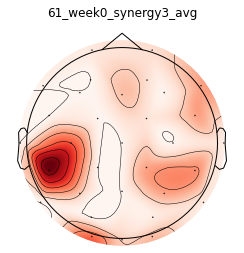

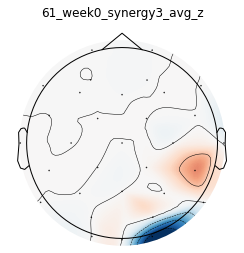

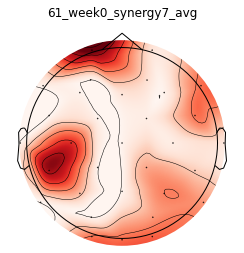

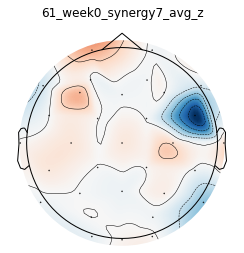

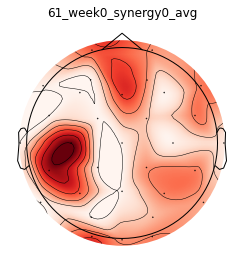

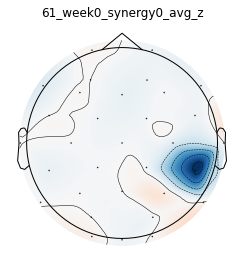

In [93]:
## Section 2-3 viz topological distribution of csc in the scalp 
# with more epochs, we should average the csc for each ch over each synergy

# This is done before viz
# use surrogate testing to extract significant ch and viz again
# we create surrogate data by selecting a segment at the begining from the synergy, then mutating it with a segment at the end with same synergy onset and offset.
# then repeat the ardl modeling
ch_z2plot = []
for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    ch_z2plot.append(ch + '_z')
for subj_idx in ['61']:  # healthy controls
    prep_epochs_dir = os.path.join(data_dir,'subj'+subj_idx,'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    epochs_prep = mne.read_epochs(epochs_fName)
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    scalp_dist_dir = os.path.join(csc_dir, 'scalp_dist')
    if not os.path.exists(scalp_dist_dir):
        os.makedirs(scalp_dist_dir)
    df_ardl_res = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'csc_ch_domain_current.csv'), index_col=0)
    
    # uncomment to see individual topo plot of each epoch
#     for _,row in df_ardl_res.iterrows():
#         subj_idx = row['subj']
#         week = row['week']
#         epoch = row['epoch']
#         synergy_label = row['synergy_label']
#         fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
#                            sharex=True, sharey=True)
#         mne.viz.plot_topomap(row[epochs_prep.copy().pick('eeg').info['ch_names']], epochs_prep.info, axes=ax, show=False)
#         ax.set_title(str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label))
#         plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '.eps'))

#         ch_z2plot = []
#         for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
#             ch_z2plot.append(ch + '_z')
#         fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
#                            sharex=True, sharey=True)
#         mne.viz.plot_topomap(row[ch_z2plot], epochs_prep.info, axes=ax, show=False)
#         ax.set_title(str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '_zCSC')
#         plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_epoch' + str(epoch) + '_synergy' + str(synergy_label) + '_zCSC.eps'))
        
#         plt.clf()
#         plt.close()

# averaged over epochs for each synergy-eeg combination
    for n_synergy in pd.unique(df_ardl_res['synergy_label']):
        csc_1synergy = df_ardl_res[df_ardl_res['synergy_label'] == n_synergy][epochs_prep.copy().pick('eeg').info['ch_names']].mean(axis=0)
        fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                           sharex=True, sharey=True)
        mne.viz.plot_topomap(csc_1synergy, epochs_prep.info, axes=ax, show=False)
        ax.set_title(str(subj_idx) + '_week0_synergy' + str(n_synergy) + '_avg')
        plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy) + '_avg.eps'))
        zcsc_1synergy = df_ardl_res[df_ardl_res['synergy_label'] == n_synergy][ch_z2plot].mean(axis=0)
        fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                           sharex=True, sharey=True)
        mne.viz.plot_topomap(zcsc_1synergy, epochs_prep.info, axes=ax, show=False)
        ax.set_title(str(subj_idx) + '_week0_synergy' + str(n_synergy)+ '_avg_z')
        plt.savefig(os.path.join(scalp_dist_dir, str(subj_idx) + '_week' + str(week) + '_synergy' + str(n_synergy) + '_avg_z.eps'))
    # for ch in epochs_prep.copy().pick('eeg').info['ch_names']:

In [5]:
## Section 2-4 viz source localization
# source localization based on weighted prep epoch (without filtering, weighted by csc), used as a reference
# results are not very accurate because of the lack of head model
# script passed test

subj_idx = 61
session = 's01'
# epoch is not specified here
synergy_label = 3
epochs2localize = df_ardl_res[(df_ardl_res['subj']==subj_idx) & (df_ardl_res['session']==session) & (df_ardl_res['trial']=='motor') &\
                           (df_ardl_res['synergy_label']==synergy_label)]['epoch']
csc_ch_domain = df_ardl_res[(df_ardl_res['subj']==subj_idx) & (df_ardl_res['session']==session) & (df_ardl_res['trial']=='motor') &\
                           (df_ardl_res['synergy_label']==synergy_label)]
# constuct csc-adjusted epoch
data_be4_csc_adjustment = epochs_prep.copy().pick('eeg').get_data()
data_csc_adjusted_epochs = []
for n_epoch in range(data_be4_csc_adjustment.shape[0]):
    if n_epoch not in epochs2localize.values:
        pass
    else:
        weighted_matrix = np.multiply(np.expand_dims(csc_ch_domain[csc_ch_domain['epoch']==n_epoch].iloc[:,6:].values[0],0).T,
                                      np.expand_dims(np.ones(data_be4_csc_adjustment[n_epoch].shape[1]),0))
        data_csc_adjusted_epochs.append(np.multiply(data_be4_csc_adjustment[n_epoch], weighted_matrix))
epochs2drop4adjusted_epochs = np.setdiff1d(range(data_be4_csc_adjustment.shape[0]), epochs2localize)
info_csc_adjusted_epochs = epochs_prep.copy().pick('eeg').drop(epochs2drop4adjusted_epochs).info
# info_csc_adjusted_epochs = mne.create_info(ch_names=epochs_prep.info['ch_names'][:n_eeg_chs], ch_types='eeg', sfreq=500)
csc_adjusted_epochs = mne.EpochsArray(data_csc_adjusted_epochs, info=info_csc_adjusted_epochs)    


# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

csc_adjusted_epochs.set_eeg_reference('average',projection=True)

# uncommwnt this if we want to plot the localization of eeg chs
mne.viz.plot_alignment(csc_adjusted_epochs.info, src=src,  trans=trans, eeg='projected',
    show_axes=True, mri_fiducials=True, dig='fiducials')

# source viz
fwd = mne.make_forward_solution(csc_adjusted_epochs.info, trans=trans, src=src,
                                bem=bem, eeg=True, mindist=5.0, n_jobs=1)


# csc_adjusted_epochs = csc_adjusted_epochs[0]  # use first epoch to mimic evoked data
evoked = csc_adjusted_epochs[1].average()
evoked.plot(time_unit='s')
evoked.plot_topomap(times=np.linspace(5, 1, 10), ch_type='eeg',
                    time_unit='s')
noise_cov = mne.compute_covariance(csc_adjusted_epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, csc_adjusted_epochs.info)
inverse_operator = make_inverse_operator(
    csc_adjusted_epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)
method = "sLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
stc, residual = apply_inverse(evoked, inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)
kwargs = dict(initial_time=0.08, hemi='lh', subjects_dir=subjects_dir,
              size=(600, 600), clim=dict(kind='percent', lims=[90, 95, 99]),
              smoothing_steps=7)
brain = stc.plot(figure=3, **kwargs)
brain.add_text(0.1, 0.9, 'sLORETA', 'title', font_size=14)

Dropped 1 epoch: 5
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
0 files missing from root.txt in /Users/ganshengt/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ganshengt/mne_data/MNE-fsaverage-data/fsaverage
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Number of events,8
Events,1: 8
Time range,0.000 – 16.000 sec
Baseline,off


# unused scripts

/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'muscle contributions for clusters before reduing synergy patterns to 4')

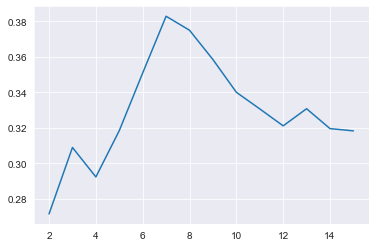

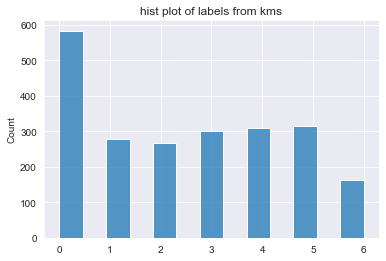

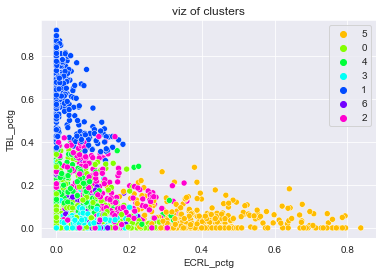

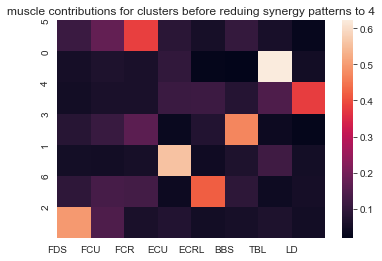

In [617]:
# Chapter 1
## Section 1-2: kNN to label synergies for patients

# paths and dir
data_dir = os.path.expanduser("/Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke")
max_n_clusters = 16
min_n_clusters = 2
n_emg_chs = 8
trial = 'motor'  # we can later expand it into a loop
    
# read synergy
synergies2df = {'FDS_pctg':[], 'FCU_pctg':[], 'FCR_pctg':[], 'ECU_pctg':[], 'ECRL_pctg':[], 'BBS_pctg':[], 'TBL_pctg':[], 'LD_pctg':[], 'subj_idx':[], 'week':[],
                'trial':[], 'epoch':[], 'synergy_id':[]}
for subj_idx in ['42','64','67','72','74']:  # loop for patients
    for week in range(4):
        synergy_fName = os.path.join(data_dir,'subj'+ subj_idx,'synergy', 'subj' + subj_idx + '_rctg_synergy.csv')
        df_synergy = pd.read_csv(synergy_fName, index_col=0)
        df_synergy_1week_motor = df_synergy[(df_synergy['trial']=='motor') & (df_synergy['week']==week)]
        for index, row in df_synergy_1week_motor.iterrows():
            for n_synergy in np.arange(1,5):
                corrected_muscle_pctg = []
                for muscle_pctg in row['synergy_' + str(n_synergy)].split(' '):
                    if muscle_pctg == '':
                        pass
                    elif '[' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[1:])
                    elif ']' in muscle_pctg:
                        if muscle_pctg[:-1] == '':
                            pass
                        else:
                            corrected_muscle_pctg.append(muscle_pctg[:-1])
                        
                    elif '\n' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[:-2])
                    else:
                        corrected_muscle_pctg.append(muscle_pctg)
                corrected_muscle_pctg_norm = np.divide(np.array(corrected_muscle_pctg).astype(float),np.array(corrected_muscle_pctg).astype(float).sum())
                for n_muscle in range(n_emg_chs):
                    synergies2df[list(synergies2df.keys())[n_muscle]].append(corrected_muscle_pctg_norm[n_muscle])
                synergies2df['subj_idx'].append(subj_idx)
                synergies2df['week'].append(week)
                synergies2df['trial'].append(row['trial'])
                synergies2df['epoch'].append(row['epoch'])
                synergies2df['synergy_id'].append(n_synergy)

df_synergy = pd.DataFrame(synergies2df)
# k means (it performs better than gm)
sil = []
for n_clusters in np.arange(min_n_clusters, max_n_clusters):
    kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
    labels = kms.labels_
    sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
plt.plot(np.arange(min_n_clusters, max_n_clusters), sil)
optimal_k = sil.index(np.max(sil)) + min_n_clusters
# optimal_k = 7
kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
labels = kms.labels_
# df_synergy['label'] = labels
# df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
plt.figure()
sns.histplot(labels)
plt.title('hist plot of labels from kms')
df_synergy['label'] = labels
# df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
plt.figure()
sns.scatterplot(df_synergy.iloc[:, 4],df_synergy.iloc[:, 6], hue=labels.astype(str), palette='hsv')
plt.title('viz of clusters')
plt.figure()
sns.heatmap(kms.cluster_centers_)
plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
plt.yticks(ticks=np.arange(optimal_k), labels=pd.unique(labels))
plt.title('muscle contributions for clusters before reduing synergy patterns to 4')

Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week0_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week1_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke/subj42/prep_epochs/motor_week2_synergy_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   16000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
16 matching

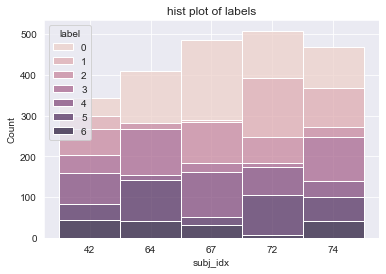

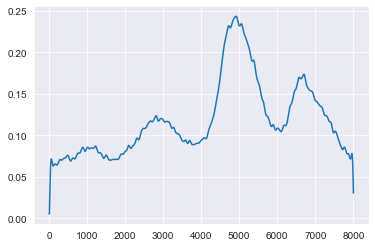

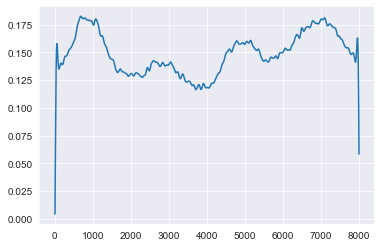

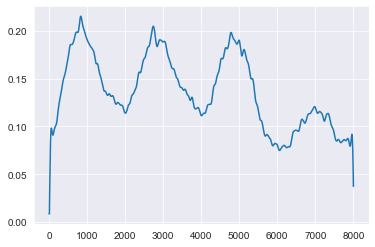

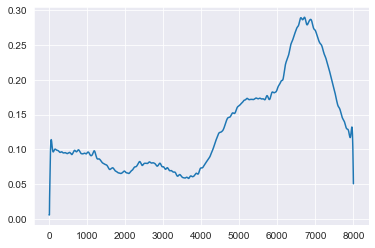

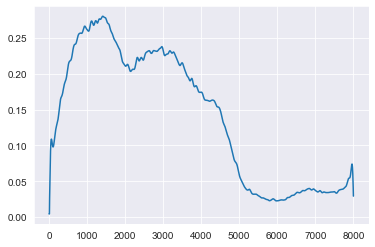

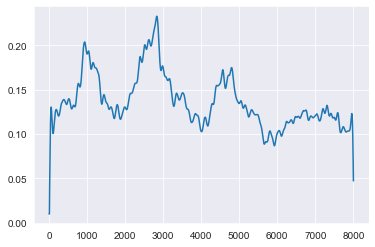

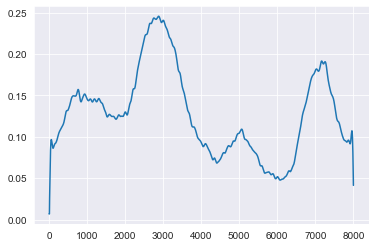

In [620]:
# individual sta
plt.figure()
sns.histplot(data=df_synergy, x='subj_idx', hue='label', multiple='stack')
plt.title('hist plot of labels')
for i in pd.unique(labels):
    exec('act_synergy_' + str(i) + '= []')
# act_synergy_10 = []

# averaged activation
for subj_idx in pd.unique(df_synergy['subj_idx']): 
    prep_epochs_dir = os.path.join(data_dir,'subj'+ str(subj_idx), 'prep_epochs')
    for week in range(4):
        epochs_prep = mne.read_epochs(os.path.join(prep_epochs_dir, 'motor_week' + str(week) + '_synergy_epo.fif'))
        for epoch in pd.unique(df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['week'] == week)]['epoch']):
            for synergy_id in range(4):
                label = df_synergy[(df_synergy['subj_idx'] == subj_idx) & (df_synergy['epoch'] == epoch) & (df_synergy['synergy_id'] == (synergy_id + 1))&
                                   (df_synergy['week'] == week)]['label'].values[0]
                exec('act_synergy_' + str(label) + '.append(epochs_prep.copy().pick("emg").get_data()[epoch][synergy_id])')
for synergy_label in pd.unique(labels):
    plt.figure()
    sns.set_style("darkgrid")
    exec('plt.plot(np.mean(act_synergy_' + str(synergy_label) + ',axis=0))')
# plt.show()

## Kmeans on all data

[5 3 1 2]
0.4223722906365322


/Users/brunnerlab/opt/anaconda3/envs/csc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'muscle contributions for clusters')

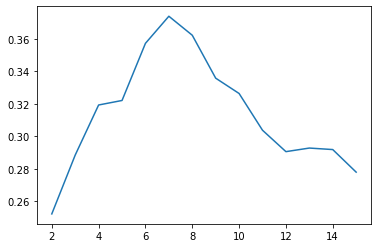

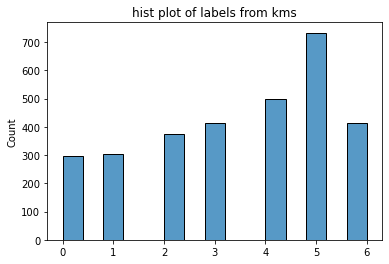

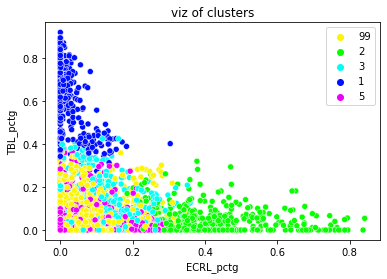

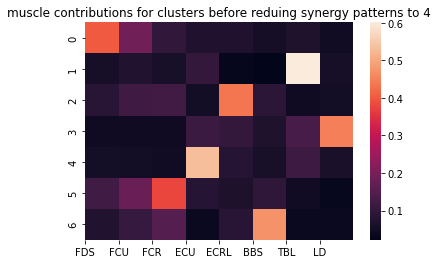

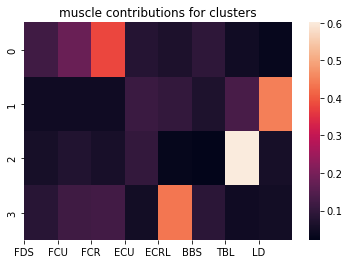

In [554]:
# Chapter 1
## Section 1-1: kNN to label synergies for all subjects
# imports
import os
import mne
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk  # to dump pca
import statsmodels.api as sm
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.datasets import fetch_fsaverage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from scipy.signal import hilbert
from scipy.stats import pearsonr
from statsmodels.tsa.api import ARDL
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.tsa.ardl import ardl_select_order
from pygam import GammaGAM, LinearGAM, s
from sklearn.mixture import GaussianMixture
from collections import Counter
from numpy.lib.stride_tricks import sliding_window_view
import pingouin as pg
from sklearn.neighbors import DistanceMetric


# paths and dir
data_dir = os.path.expanduser("/Users/brunnerlab/Desktop/GT/gCMN/MultiEEGEMG_stroke")
max_n_clusters = 16
min_n_clusters = 2
n_emg_chs = 8
trial = 'motor'  # we can later expand it into a loop
    
# read synergy
synergies2df = {'FDS_pctg':[], 'FCU_pctg':[], 'FCR_pctg':[], 'ECU_pctg':[], 'ECRL_pctg':[], 'BBS_pctg':[], 'TBL_pctg':[], 'LD_pctg':[], 'subj_idx':[], 'week':[],
                'trial':[], 'epoch':[], 'synergy_id':[]}
for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # loop for healthy people
    synergy_fName = os.path.join(data_dir,'subj'+ subj_idx,'synergy', 'subj' + subj_idx + '_rctg_synergy.csv')
    df_synergy_1session = pd.read_csv(synergy_fName, index_col=0)
    df_synergy_1session_motor = df_synergy_1session[df_synergy_1session['trial']=='motor']
    for index, row in df_synergy_1session_motor.iterrows():
        for n_synergy in np.arange(1,5):
            corrected_muscle_pctg = []
            for muscle_pctg in row['synergy_' + str(n_synergy)].split(' '):
                if '[' in muscle_pctg:
                    corrected_muscle_pctg.append(muscle_pctg[1:])
                elif ']' in muscle_pctg:
                    if muscle_pctg[:-1] == '':
                        pass
                    else:
                        corrected_muscle_pctg.append(muscle_pctg[:-1])
                elif '\n' in muscle_pctg:
                    corrected_muscle_pctg.append(muscle_pctg[:-2])
                elif muscle_pctg == '':
                    pass
                else:
                    corrected_muscle_pctg.append(muscle_pctg)
            corrected_muscle_pctg_norm = np.divide(np.array(corrected_muscle_pctg).astype(float),np.array(corrected_muscle_pctg).astype(float).sum())
            for n_muscle in range(n_emg_chs):
                synergies2df[list(synergies2df.keys())[n_muscle]].append(corrected_muscle_pctg_norm[n_muscle])
            # for n_muscle in range(n_emg_chs):
            #     synergies2df[list(synergies2df.keys())[n_muscle]].append(np.round(float(corrected_muscle_pctg[n_muscle]), 3))
            synergies2df['subj_idx'].append(subj_idx)
            synergies2df['week'].append(0)
            synergies2df['trial'].append(row['trial'])
            synergies2df['epoch'].append(row['epoch'])
            synergies2df['synergy_id'].append(n_synergy)
            
for subj_idx in ['42','64','67','72','74']:  # loop for patients
    for week in range(4):
        synergy_fName = os.path.join(data_dir,'subj'+ subj_idx,'synergy', 'subj' + subj_idx + '_rctg_synergy.csv')
        df_synergy = pd.read_csv(synergy_fName, index_col=0)
        df_synergy_1week_motor = df_synergy[(df_synergy['trial']=='motor') & (df_synergy['week']==week)]
        for index, row in df_synergy_1week_motor.iterrows():
            for n_synergy in np.arange(1,5):
                corrected_muscle_pctg = []
                for muscle_pctg in row['synergy_' + str(n_synergy)].split(' '):
                    if muscle_pctg == '':
                        pass
                    elif '[' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[1:])
                    elif ']' in muscle_pctg:
                        if muscle_pctg[:-1] == '':
                            pass
                        else:
                            corrected_muscle_pctg.append(muscle_pctg[:-1])
                        
                    elif '\n' in muscle_pctg:
                        corrected_muscle_pctg.append(muscle_pctg[:-2])
                    else:
                        corrected_muscle_pctg.append(muscle_pctg)
                corrected_muscle_pctg_norm = np.divide(np.array(corrected_muscle_pctg).astype(float),np.array(corrected_muscle_pctg).astype(float).sum())
                for n_muscle in range(n_emg_chs):
                    synergies2df[list(synergies2df.keys())[n_muscle]].append(corrected_muscle_pctg_norm[n_muscle])
                synergies2df['subj_idx'].append(subj_idx)
                synergies2df['week'].append(week)
                synergies2df['trial'].append(row['trial'])
                synergies2df['epoch'].append(row['epoch'])
                synergies2df['synergy_id'].append(n_synergy)


# :df_synergy = pd.concat(list_dfs_synergy)
df_synergy = pd.DataFrame(synergies2df)

# normalization

# k means (it performs better than gm)
sil = []
for n_clusters in np.arange(min_n_clusters, max_n_clusters):
    kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
    labels = kms.labels_
    sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
plt.plot(np.arange(min_n_clusters, max_n_clusters), sil)
optimal_k = sil.index(np.max(sil)) + min_n_clusters
# optimal_k = 7
kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
labels = kms.labels_
# df_synergy['label'] = labels
# df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
plt.figure()
sns.histplot(labels)
plt.title('hist plot of labels from kms')


# Method 1: set threshold and code artifactual synergy as 99
# for now, we classify artifactual synergy based on the number of the types
# we can also classifiy artifactual synergies based on their distance to the center
# n_threshold = len(labels) * 0.15
# artifact_code = 99
# counts  = Counter(labels)
# labels2recode = []
# clusters_center= []
# labels_thresholded = labels
# for synergy_label in counts.keys():
#     if counts[synergy_label] < n_threshold:
#         labels2recode.append(synergy_label)
#         labels_thresholded[labels_thresholded == synergy_label] = artifact_code
#     else:  # if the number of synergies of a kind passes the threshold, then this kind (cluster center) is saved
#         clusters_center.append(kms.cluster_centers_[synergy_label])
# df_synergy['label'] = labels_thresholded
        
# Method 2: label '99' based on the distance
# distances = []
# quantile = 0.9
# dist = DistanceMetric.get_metric('euclidean')
# X = df_synergy.iloc[:, :n_emg_chs]
# for i in range(len(labels)):
#     distances.append(dist.pairwise([X.iloc[i,:], clusters_center[labels[i]]])[0,1])
# distance_threshold = np.quantile(distances, quantile)
# for i in range(len(distances)):
#     if distances[i] > distance_threshold:
#         labels[i] = 99
# df_synergy['label'] = labels
# print(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))

# Method 3: we take 
from collections import Counter
label_values = np.array(list(Counter(labels).values()))
label_keys2keep = np.argsort(label_values)[:4]
for i in range(len(labels)):
    if labels[i] not in label_keys2keep:
        labels[i] = 99
clusters_center = []
for label in label_keys2keep:
    clusters_center.append(kms.cluster_centers_[label])
print(label_keys2keep)
df_synergy['label'] = labels
df_synergy_threshold = df_synergy[df_synergy['label'] != 99]
print(silhouette_score(df_synergy_threshold.iloc[:, :n_emg_chs], df_synergy_threshold['label'], metric = 'euclidean'))  

df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
plt.figure()
sns.scatterplot(df_synergy.iloc[:, 4],df_synergy.iloc[:, 6], hue=labels.astype(str), palette='hsv')
plt.title('viz of clusters')
plt.figure()
sns.heatmap(kms.cluster_centers_)
plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
plt.title('muscle contributions for clusters before reduing synergy patterns to 4')
plt.figure()
sns.heatmap(clusters_center)
plt.xticks(ticks=np.arange(8), labels=['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD'])
plt.title('muscle contributions for clusters')
# viz cluster center

# additional scripts
# compare k_means and GM with k means init
# sil = []
# for n_clusters in np.arange(3, max_n_clusters):
#     kms = KMeans(n_clusters=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
#     labels = kms.labels_
#     sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels, metric = 'euclidean'))
# plt.plot(np.arange(3, max_n_clusters), sil)
# optimal_k = sil.index(np.max(sil)) + 3
# kms = KMeans(n_clusters=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
# labels = kms.labels_
# plt.figure()
# sns.scatterplot(df_synergy.iloc[:, 0],df_synergy.iloc[:, 1], hue=labels, palette='hsv')
# plt.figure()
# sns.histplot(labels)

# sil = []
# for n_clusters in np.arange(3, max_n_clusters):
#     gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
#     labels = gm.predict(df_synergy.iloc[:, :n_emg_chs])
#     sil.append(silhouette_score(df_synergy.iloc[:, :n_emg_chs], labels))
# plt.figure()
# plt.plot(np.arange(3, max_n_clusters), sil)
# optimal_k = sil.index(np.max(sil)) + 3
# # optimal_k = 4
# gm = GaussianMixture(n_components=optimal_k, random_state=0).fit(df_synergy.iloc[:, :n_emg_chs])
# labels = gm.predict(df_synergy.iloc[:, :n_emg_chs])
# # df_synergy['label'] = labels
# # df_synergy.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'))
# plt.figure()
# sns.scatterplot(df_synergy.iloc[:, 0],df_synergy.iloc[:, 1], hue=labels, palette='hsv')

# End of csc analysis

In [ ]:
## Section 3-2 model the synergy based on specogram
# pca inversion passed the test, the order of chs is correct
from random import random, seed, shuffle
seed(99)
noverlap = 128
# fc to calculate z score
def z_srg(x, srg):
    '''
    x: float, value
    srg: array-like, std data
    '''
    if np.nonzero(srg)[0].shape[0] > 0: 
        return (x - np.mean(srg)) / np.std(srg)
    else:
        return 0

# parameters   
n_eeg_chs = 32
n_srg = 25
# reseting    
plt.close()
plt.clf()
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# read synergies info
df_synergy = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'), index_col=0)

# retrieve epochs info
prep_epochs_dir = os.path.join(data_dir, 'subj61', 'prep_epochs')  # use 61 as an example
epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
epochs_prep = mne.read_epochs(epochs_fName)
ardl_res2df = {'subj': [],
               'week': [],
               'trial': [],
               'epoch': [],
               'synergy_label': [],
               'ardl_order': [],
              'aic':[],
              'explained_v':[]}
for ch in epochs_prep.copy().pick('eeg').info['ch_names']:
    ardl_res2df[ch] = []
    ardl_res2df[ch + '_z'] = []  # z-scored
    
# for subj_idx in ['61', '65', '66', '68', '69', '70', '71']:  # healthy controls
for subj_idx in ['61']:  # for testing
    csc_dir = os.path.join(data_dir,'subj'+subj_idx,'csc')
    # pca_dir = os.path.join(csc_dir, 'pca')
    # if not os.path.exists(pca_dir):
    #     os.makedirs(pca_dir)
    Mf_2D = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_Mf.csv'))
    Mf = Mf_2D.reshape(Mf_2D.shape[0], n_eeg_chs, Mf_2D.shape[1] // n_eeg_chs)

    # get synergies
    prep_epochs_dir = os.path.join(data_dir, 'subj' + subj_idx, 'prep_epochs')
    epochs_fName = os.path.join(prep_epochs_dir, 'motor_synergy_epo.fif')
    epochs_prep = mne.read_epochs(epochs_fName)
    synergies = epochs_prep.copy().pick(['emg']).get_data()

    for n_epoch in range(Mf.shape[0]):
    # for n_epoch in range(2):  # for test
        print('epoch ' + n_epoch)
        Mf_1epoch = Mf[n_epoch]  # some chs can be 0 because no peek was detected
        synergies_1epoch = synergies[n_epoch]
        pca=PCA(n_components=0.95, random_state=97)  
        Tf_1epoch = pca.fit_transform(Mf_1epoch.T)  # avoid collinearity

        for n_synergy in range(synergies_1epoch.shape[0]):
            synergy_label = df_synergy[(df_synergy['week'] == 0) & (df_synergy['trial']== 'motor') &
                                       (df_synergy['epoch'] == n_epoch) & (df_synergy['synergy_id']==n_synergy + 1)]['label'].values[0]
            # calculate moving average of the synergy to match the length of Tf
            
            # sel_res = ardl_select_order(synergies_1epoch[n_synergy], 0, Tf_1epoch, 2, ic="aic", trend="c")  # select the best model based on AIC
            # calculate differentiation
            # synergies_1epoch_diff = np.subtract(synergies_1epoch[:, 1:], synergies_1epoch[:, :-1])
            sel_res = ardl_select_order(synergies_1epoch_diff[n_synergy], 0, Tf_1epoch_env[:-1, :], 2, ic="aic", trend="c")  # use diff as predicter
            res = sel_res.model.fit()
            # construct ch spaces coherence
            number_pca_components = pca.components_.shape[0]
            # construct coherence matrix in pca domain
            csc_pca_domain = []
            # current_row = 2  # updated in the loop, row 0 and row 1 are respectively constant and y_t-1
            current_row = 1  # updated in the loop, row 0 is the constant
            for n_pca_components in range(number_pca_components):
                if n_pca_components in sel_res.model.dl_lags.keys():
                    if len(sel_res.model.dl_lags[n_pca_components])==3:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]) + np.abs(res.tvalues[current_row + 2]))
                        current_row += 3
                    elif len(sel_res.model.dl_lags[n_pca_components])==2:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]))
                        current_row += 2
                    elif len(sel_res.model.dl_lags[n_pca_components])==1:
                        csc_pca_domain.append(np.abs(res.tvalues[current_row]))
                        current_row += 1
                    else:
                        assert False, 'lag more than 3'
                else:
                    csc_pca_domain.append(0)
            csc_ch_domain = pca.inverse_transform(csc_pca_domain)
            ardl_res2df['subj'].append(subj_idx)
            ardl_res2df['week'].append(0)
            ardl_res2df['trial'].append('motor')
            ardl_res2df['epoch'].append(n_epoch)
            ardl_res2df['ardl_order'].append(sel_res.model.ardl_order)
            ardl_res2df['synergy_label'].append(synergy_label)
            ardl_res2df['aic'].append(res.aic)
            # ardl_res2df['explained_v'].append(explained_variance_score(synergies_1epoch[n_synergy][1:],res.fittedvalues))
            ardl_res2df['explained_v'].append(explained_variance_score(synergies_1epoch_diff[n_synergy][(synergies_1epoch_diff[n_synergy].shape[0] - res.fittedvalues.shape[0]):],
                                                                       res.fittedvalues))  # if we decide to not include y(t-1)
            for n_ch in range(n_eeg_chs):
                ardl_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch]].append(np.abs(csc_ch_domain[n_ch]))  # csc represents coherence (>0)
                
            #  uncomment those to check the performance
            # print(res.summary())
            # res.plot_predict(figsize=(12,5))
            # figure = plt.gca()
            # figure.plot(synergies_1epoch_diff[n_synergy][:res.fittedvalues.shape[0]], c='r', linestyle='--')
            # plt.title('synergy_' + str(synergy_label))
            # print(explained_variance_score(synergies_1epoch_diff[n_synergy][(synergies_1epoch_diff[n_synergy].shape[0] - res.fittedvalues.shape[0]):],
            #                                                            res.fittedvalues))

            # generate srg synergies - less intrusive way
            # randomly select synergy activation to segment the activation course more than 4 but less than 10 segments
            # save the indexes as a dict, randomly shuffle the keys of the dict.
            
            csc_ch_domain_srg_list = []
            for srg_idx in range(n_srg):
                cut_points_del_neignbors = np.array([])
                while cut_points_del_neignbors.shape[0] < 4:
                    synergy_value_range = (synergies_1epoch[n_synergy].max() - synergies_1epoch[n_synergy].min())  # for srg generation, synergy data are discrete, 
                                                                                                               # we need a range to select segments that have same onset/offset values
                    element_wise_diff_max =  np.max(synergies_1epoch[n_synergy][1:] - synergies_1epoch[n_synergy][:-1])
                    segment_mean = random() * synergy_value_range 
                    segment_max = segment_mean + element_wise_diff_max
                    segment_min = segment_mean - element_wise_diff_max
                    cut_points = np.where((synergies_1epoch[n_synergy] < segment_max) & (synergies_1epoch[n_synergy] > segment_min))[0]
                    cut_points_del_neignbors = cut_points[np.where((cut_points[1:] - cut_points[:-1]) > 2)]  # delete neighbors of those cut points
                    # print(cut_points_del_neignbors)
                # create segment tuples
                cut_segments = []
                for i in range(cut_points_del_neignbors.shape[0]-1):
                    cut_segments.append((cut_points_del_neignbors[i], cut_points_del_neignbors[i+1]))
                # print(cut_segments)
                shuffle(cut_segments)
                cut_segments.insert(0, (0, cut_points_del_neignbors[0]))
                cut_segments.append((cut_points_del_neignbors[-1], synergies_1epoch[n_synergy].shape[0]))
                synergy_srg = []
                # plt.figure()
                # plt.plot(synergies_1epoch[n_synergy])
                for segment in cut_segments:
                    synergy_srg += synergies_1epoch[n_synergy][segment[0]:segment[1]].tolist()
                # plt.plot(synergy_srg)

    #             # intrusive block shuffling
    #             blocksize = 100

    #             # Create blocks
    #             blocks = [synergies_1epoch[n_synergy][i : i + blocksize] for i in range(0,len(synergies_1epoch[n_synergy]),blocksize)]
    #             # shuffle the blocks
    #             shuffle(blocks)
    #             # concatenate the shuffled blocks
    #             synergy_srg = []
    #             synergy_srg[:] = [b for bs in blocks for b in bs]
    #             plt.plot(synergy_srg)
                synergy_diff_srg = np.subtract(synergy_srg[1:], synergy_srg[:-1])
                sel_res = ardl_select_order(synergy_diff_srg, 0, Tf_1epoch_env[:-1, :], 2, ic="aic", trend="c")  # select the best model based on AIC
                res = sel_res.model.fit()
                
                # construct ch spaces coherence
                number_pca_components = pca.components_.shape[0]
                # construct coherence matrix in pca domain
                csc_pca_domain = []
                # current_row = 2  # updated in the loop, row 0 and row 1 are respectively constant and y_t-1
                current_row = 1  # updated in the loop, row 0 is the constant
                for n_pca_components in range(number_pca_components):
                    if n_pca_components in sel_res.model.dl_lags.keys():
                        if len(sel_res.model.dl_lags[n_pca_components])==3:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]) + np.abs(res.tvalues[current_row + 2]))
                            current_row += 3
                        elif len(sel_res.model.dl_lags[n_pca_components])==2:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]) + np.abs(res.tvalues[current_row + 1]))
                            current_row += 2
                        elif len(sel_res.model.dl_lags[n_pca_components])==1:
                            csc_pca_domain.append(np.abs(res.tvalues[current_row]))
                            current_row += 1
                        else:
                            assert False, 'lag more than 3'
                    else:
                        csc_pca_domain.append(0)
                csc_ch_domain_srg = pca.inverse_transform(csc_pca_domain)
                csc_ch_domain_srg_list.append(np.abs(csc_ch_domain_srg))
                
                # # performance check
                # print(explained_variance_score(synergy_diff_srg[(synergy_diff_srg.shape[0] - res.fittedvalues.shape[0]):],
                #                                                        res.fittedvalues))
            csc_ch_domain_dist = np.vstack(csc_ch_domain_srg_list)
            for n_ch in range(n_eeg_chs):
                ardl_res2df[epochs_prep.copy().pick('eeg').info['ch_names'][n_ch] + '_z'].append(z_srg(np.abs(csc_ch_domain[n_ch]), 
                                                                                                      csc_ch_domain_dist[:, n_ch]))  # csc represents coherence (>0)
            # print(res.summary())
            
 
        # uncomment those to see the correlation between the 1st order derivative of synergy and pca components
#         plt.figure()
#         plt.plot(np.gradient(synergies_1epoch[n_synergy], 1/500))
#         plt.plot(Tf_1epoch.T[3]*4e5)
#         print(pearsonr(np.gradient(synergies_1epoch[n_synergy], 1/500),Tf_1epoch.T[4] ))
#         for i in range(20):
#             plt.figure(figsize=(10,10))
#             plt.scatter(Hf_phase_1epoch[i]*8e4,synergies_1epoch[n_synergy])
# #             print(pearsonr(Hf_phase_1epoch[i]*8e4,synergies_1epoch[n_synergy])[0])
# #             plt.plot(Hf_amp_1epoch[i]*8e4)
# #             plt.plot(synergies_1epoch[n_synergy])
#             plt.title(str(synergy_label.values[0]) + '-' + str(i))
#         print(gam.summary())
#     Tf_1epoch_amp
#     plt.figure()
#     sns.heatmap(Tf_1epoch)


#save df
df_ardl_res = pd.DataFrame(ardl_res2df)
df_ardl_res.to_csv(os.path.join(data_dir, 'temp', 'rCSC', 'csc_ch_domain_current.csv'))
# switch back to the default setting
warnings.filterwarnings("default", category=ResourceWarning)
warnings.filterwarnings("default", category=DeprecationWarning)

In [247]:
kwargs = dict(initial_time=0.08, hemi='lh', subjects_dir=subjects_dir,
              size=(600, 600), clim=dict(kind='percent', lims=[90, 95, 99]),
              smoothing_steps=7)
brain = stc.plot(figure=3, **kwargs)
brain.add_text(0.1, 0.9, 'sLORETA', 'title', font_size=14)

Using control points [0.65825967 0.81666625 1.20112882]


/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:66: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  if numpy_array_type == key or \
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:68: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  numpy_array_type == numpy.dtype(key):
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/vtkmodules/util/numpy_support.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is saf

In [60]:
res = ARDL(synergies_1epoch[n_synergy], 1, Tf_1epoch, 0).fit()
print(res.summary())
print(explained_variance_score(synergies_1epoch[n_synergy][1:],res.fittedvalues))

                                      ARDL Model Results                                      
Dep. Variable:                                      y   No. Observations:                 8001
Model:             ARDL(1, 0, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood               41800.345
Method:                               Conditional MLE   S.D. of innovations              0.001
Date:                                Fri, 28 Jan 2022   AIC                         -83576.689
Time:                                        12:27:48   BIC                         -83492.843
Sample:                                             1   HQIC                        -83547.990
                                                 8001                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.746e-05   3.98e-05      1.444      0.149   -2.05e-05       0.000
y.L

In [23]:
## Section 2-2 tentative, PCA on analytical signal - use gam instead of linear reg - scatterplots do not show clear tendency, ev is low (<50)
## pearsonr is alsp low
# read synergies info, 
df_synergy = pd.read_csv(os.path.join(data_dir, 'temp', 'rCSC', 'labeled_synergies.csv'), index_col=0)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
n_eeg_chs = 32
Mf_2D = np.loadtxt(os.path.join(csc_dir, 'subj' + subj_idx + '_rctg_' + session_idx + '_Mf.csv'))
Mf = Mf_2D.reshape(Mf_2D.shape[0], n_eeg_chs, Mf_2D.shape[1] // n_eeg_chs)
Tf_amp = []
Tf_phase = []
pca_dir = os.path.join(csc_dir, 'pca')
if not os.path.exists(pca_dir):
    os.makedirs(pca_dir)
# get synergies
synergies = epochs_prep.copy().pick(['emg']).get_data()
# run PCA for each epoch
for n_epoch in range(Mf.shape[0]):
    Mf_1epoch = Mf[n_epoch]
    synergies_1epoch = synergies[n_epoch]
    Hf_amp_1epoch = []
    Hf_phase_1epoch = []
    for n_ch in range(Mf_1epoch.shape[0]):  # apply hilbert on each ch
        analytic_signal = hilbert(Mf_1epoch[n_ch])
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.angle(analytic_signal)  # from -2pi to 2pi
        instantaneous_frequency = (np.diff(np.unwrap(instantaneous_phase)) /
                               (2.0*np.pi) * 500)
        Hf_amp_1epoch.append(amplitude_envelope)
        Hf_phase_1epoch.append(instantaneous_phase)
    pca=PCA(n_components=0.95, random_state=97)
    Tf_amp_1epoch = pca.fit_transform(np.array(Hf_amp_1epoch).T)
    pk.dump(pca, open("subj" + subj_idx + '_' + session_idx + "_motor_amp_pca.pkl", "wb"))
    pca=PCA(n_components=0.95, random_state=97)
    Tf_phase_1epoch = pca.fit_transform(np.array(Hf_phase_1epoch).T)
    pk.dump(pca, open("subj" + subj_idx + '_' + session_idx + "_motor_phase_pca.pkl", "wb"))
    # to load pca class
#     with open('pca.pkl', 'rb') as pickle_file:
#         pca = pickle.load(pickle_file)
    
    Tf_amp.append(Tf_amp_1epoch.T)
    Tf_phase.append(Tf_phase_1epoch.T)
    for n_synergy in range(synergies_1epoch.shape[0]):
        synergy_label = df_synergy[(df_synergy['session'] == session_idx) & (df_synergy['trial']== 'motor') &
                                   (df_synergy['epoch'] == n_epoch) & (df_synergy['synergy_id']==n_synergy + 1)]['label']
        s_term_expression = ''
        for i in range(Tf_amp_1epoch.shape[1]):
            if i == 0:
                s_term_expression += 's(' + str(i) + ')'
            else:
                s_term_expression += '+s(' + str(i) + ')'
        exec('gam = LinearGAM(' + s_term_expression + ').fit(Tf_amp_1epoch, synergies_1epoch[n_synergy])')
        print(explained_variance_score(synergies_1epoch[n_synergy], gam.predict(Tf_amp_1epoch)))
#         for i in range(Tf_amp_1epoch.shape[1]):
#             plt.figure()
#             plt.scatter(Tf_amp_1epoch[:,i],synergies_1epoch[n_synergy])
#             plt.title(str(synergy_label.values[0]) + '-' + str(i))
        print(gam.summary())
#     Tf_1epoch_amp
#     plt.figure()
#     sns.heatmap(Tf_1epoch)
    
    # Multiple regression for each synergy - did not perform well
#     synergies_1epoch = synergies[n_epoch]
#     for synergy in synergies_1epoch:
#         reg = LR().fit(Tf_1epoch,synergy)
#         print(reg.score(Tf_1epoch,synergy))

#save Tf

# switch back to the default setting
warnings.filterwarnings("default", category=ResourceWarning)
warnings.filterwarnings("default", category=DeprecationWarning)

0.31474093652476753
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.0893
Link Function:                     IdentityLink Log Likelihood:                               -2420898.116
Number of Samples:                         8001 AIC:                                          4842144.4105
                                                AICc:                                         4842152.2003
                                                GCV:                                                0.0017
                                                Scale:                                              0.0016
                                                Pseudo R-Squared:                                   0.3147
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.41989708144305793
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.0893
Link Function:                     IdentityLink Log Likelihood:                              -1568665.7638
Number of Samples:                         8001 AIC:                                          3137679.7062
                                                AICc:                                          3137687.496
                                                GCV:                                                0.0025
                                                Scale:                                              0.0024
                                                Pseudo R-Squared:                                   0.4199
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3583702120831219
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.0893
Link Function:                     IdentityLink Log Likelihood:                              -1732457.7201
Number of Samples:                         8001 AIC:                                          3465263.6187
                                                AICc:                                         3465271.4085
                                                GCV:                                                0.0023
                                                Scale:                                              0.0022
                                                Pseudo R-Squared:                                   0.3584
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2837063122051411
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.0893
Link Function:                     IdentityLink Log Likelihood:                               -731337.5181
Number of Samples:                         8001 AIC:                                          1463023.2147
                                                AICc:                                         1463031.0045
                                                GCV:                                                0.0053
                                                Scale:                                              0.0051
                                                Pseudo R-Squared:                                   0.2837
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.35353732217287703
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.3458
Link Function:                     IdentityLink Log Likelihood:                              -1253390.9717
Number of Samples:                         8001 AIC:                                           2507140.635
                                                AICc:                                         2507148.9065
                                                GCV:                                                0.0032
                                                Scale:                                               0.003
                                                Pseudo R-Squared:                                   0.3535
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3579842297809622
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.3458
Link Function:                     IdentityLink Log Likelihood:                              -1140231.9016
Number of Samples:                         8001 AIC:                                          2280822.4948
                                                AICc:                                         2280830.7663
                                                GCV:                                                0.0035
                                                Scale:                                              0.0033
                                                Pseudo R-Squared:                                    0.358
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.32294923051510915
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.3458
Link Function:                     IdentityLink Log Likelihood:                               -733621.8375
Number of Samples:                         8001 AIC:                                          1467602.3665
                                                AICc:                                          1467610.638
                                                GCV:                                                0.0053
                                                Scale:                                              0.0051
                                                Pseudo R-Squared:                                   0.3229
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.5361855628512843
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.3458
Link Function:                     IdentityLink Log Likelihood:                              -1482513.0535
Number of Samples:                         8001 AIC:                                          2965384.7985
                                                AICc:                                           2965393.07
                                                GCV:                                                0.0027
                                                Scale:                                              0.0026
                                                Pseudo R-Squared:                                   0.5362
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2823364069646217
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.7689
Link Function:                     IdentityLink Log Likelihood:                              -1832667.0249
Number of Samples:                         8001 AIC:                                          3665685.5876
                                                AICc:                                         3665693.5298
                                                GCV:                                                0.0022
                                                Scale:                                              0.0021
                                                Pseudo R-Squared:                                   0.2823
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2868828628705593
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.7689
Link Function:                     IdentityLink Log Likelihood:                              -2282210.7367
Number of Samples:                         8001 AIC:                                          4564773.0113
                                                AICc:                                         4564780.9534
                                                GCV:                                                0.0018
                                                Scale:                                              0.0017
                                                Pseudo R-Squared:                                   0.2869
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.32709887303273943
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.7689
Link Function:                     IdentityLink Log Likelihood:                              -1052926.3396
Number of Samples:                         8001 AIC:                                          2106204.2169
                                                AICc:                                          2106212.159
                                                GCV:                                                0.0037
                                                Scale:                                              0.0036
                                                Pseudo R-Squared:                                   0.3271
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.268047730182697
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.7689
Link Function:                     IdentityLink Log Likelihood:                              -1087791.0565
Number of Samples:                         8001 AIC:                                          2175933.6508
                                                AICc:                                          2175941.593
                                                GCV:                                                0.0036
                                                Scale:                                              0.0035
                                                Pseudo R-Squared:                                    0.268
Feature Function   

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2820443933246668
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    176.7829
Link Function:                     IdentityLink Log Likelihood:                              -2213529.5864
Number of Samples:                         8001 AIC:                                          4427414.7385
                                                AICc:                                         4427422.8653
                                                GCV:                                                0.0018
                                                Scale:                                              0.0017
                                                Pseudo R-Squared:                                    0.282
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.22751554955965814
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    176.7829
Link Function:                     IdentityLink Log Likelihood:                              -1384391.2098
Number of Samples:                         8001 AIC:                                          2769137.9854
                                                AICc:                                         2769146.1121
                                                GCV:                                                0.0029
                                                Scale:                                              0.0027
                                                Pseudo R-Squared:                                   0.2275
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.30097265577139454
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    176.7829
Link Function:                     IdentityLink Log Likelihood:                               -599857.8357
Number of Samples:                         8001 AIC:                                          1200071.2371
                                                AICc:                                         1200079.3639
                                                GCV:                                                0.0064
                                                Scale:                                              0.0062
                                                Pseudo R-Squared:                                    0.301
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.27029684798982234
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    176.7829
Link Function:                     IdentityLink Log Likelihood:                               -532275.2603
Number of Samples:                         8001 AIC:                                          1064906.0863
                                                AICc:                                         1064914.2131
                                                GCV:                                                0.0072
                                                Scale:                                              0.0069
                                                Pseudo R-Squared:                                   0.2703
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.4326127817538098
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.9967
Link Function:                     IdentityLink Log Likelihood:                              -1651668.4145
Number of Samples:                         8001 AIC:                                          3303696.8225
                                                AICc:                                         3303705.1546
                                                GCV:                                                0.0024
                                                Scale:                                              0.0023
                                                Pseudo R-Squared:                                   0.4326
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.31559942040167877
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.9967
Link Function:                     IdentityLink Log Likelihood:                              -1550685.3889
Number of Samples:                         8001 AIC:                                          3101730.7711
                                                AICc:                                         3101739.1033
                                                GCV:                                                0.0026
                                                Scale:                                              0.0025
                                                Pseudo R-Squared:                                   0.3156
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.29994812630324896
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.9967
Link Function:                     IdentityLink Log Likelihood:                               -488973.9503
Number of Samples:                         8001 AIC:                                           978307.8939
                                                AICc:                                          978316.2261
                                                GCV:                                                0.0078
                                                Scale:                                              0.0075
                                                Pseudo R-Squared:                                   0.2999
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2529780415195343
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    178.9967
Link Function:                     IdentityLink Log Likelihood:                               -556614.4272
Number of Samples:                         8001 AIC:                                          1113588.8477
                                                AICc:                                         1113597.1799
                                                GCV:                                                0.0069
                                                Scale:                                              0.0066
                                                Pseudo R-Squared:                                    0.253
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3833393807103329
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    177.6936
Link Function:                     IdentityLink Log Likelihood:                              -3372730.2983
Number of Samples:                         8001 AIC:                                          6745817.9838
                                                AICc:                                         6745826.1948
                                                GCV:                                                0.0012
                                                Scale:                                              0.0011
                                                Pseudo R-Squared:                                   0.3833
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.36643748853905356
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    177.6936
Link Function:                     IdentityLink Log Likelihood:                              -3817844.1067
Number of Samples:                         8001 AIC:                                          7636045.6005
                                                AICc:                                         7636053.8115
                                                GCV:                                                0.0011
                                                Scale:                                               0.001
                                                Pseudo R-Squared:                                   0.3664
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.36428995262222896
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    177.6936
Link Function:                     IdentityLink Log Likelihood:                               -1320247.527
Number of Samples:                         8001 AIC:                                          2640852.4411
                                                AICc:                                         2640860.6521
                                                GCV:                                                 0.003
                                                Scale:                                              0.0029
                                                Pseudo R-Squared:                                   0.3643
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.2945734956127354
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    177.6936
Link Function:                     IdentityLink Log Likelihood:                              -1061782.3622
Number of Samples:                         8001 AIC:                                          2123922.1115
                                                AICc:                                         2123930.3224
                                                GCV:                                                0.0037
                                                Scale:                                              0.0036
                                                Pseudo R-Squared:                                   0.2946
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3936383590760961
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.4998
Link Function:                     IdentityLink Log Likelihood:                              -1044882.4699
Number of Samples:                         8001 AIC:                                          2090113.9394
                                                AICc:                                         2090121.7663
                                                GCV:                                                0.0038
                                                Scale:                                              0.0036
                                                Pseudo R-Squared:                                   0.3936
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.4082874008038627
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.4998
Link Function:                     IdentityLink Log Likelihood:                              -1496587.0412
Number of Samples:                         8001 AIC:                                          2993523.0821
                                                AICc:                                          2993530.909
                                                GCV:                                                0.0026
                                                Scale:                                              0.0025
                                                Pseudo R-Squared:                                   0.4083
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.331459557415561
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.4998
Link Function:                     IdentityLink Log Likelihood:                               -408340.5276
Number of Samples:                         8001 AIC:                                           817030.0548
                                                AICc:                                          817037.8817
                                                GCV:                                                0.0093
                                                Scale:                                              0.0089
                                                Pseudo R-Squared:                                   0.3315
Feature Function   

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3610132119005893
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    173.4998
Link Function:                     IdentityLink Log Likelihood:                                -1298730.19
Number of Samples:                         8001 AIC:                                          2597809.3796
                                                AICc:                                         2597817.2065
                                                GCV:                                                 0.003
                                                Scale:                                              0.0029
                                                Pseudo R-Squared:                                    0.361
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.4038534102011524
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.8307
Link Function:                     IdentityLink Log Likelihood:                               -725203.3405
Number of Samples:                         8001 AIC:                                          1450758.3425
                                                AICc:                                         1450766.2902
                                                GCV:                                                0.0054
                                                Scale:                                              0.0051
                                                Pseudo R-Squared:                                   0.4039
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.33075044186699076
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.8307
Link Function:                     IdentityLink Log Likelihood:                              -1768845.8401
Number of Samples:                         8001 AIC:                                          3538043.3415
                                                AICc:                                         3538051.2893
                                                GCV:                                                0.0022
                                                Scale:                                              0.0022
                                                Pseudo R-Squared:                                   0.3308
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.35907672194421947
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.8307
Link Function:                     IdentityLink Log Likelihood:                               -462594.6954
Number of Samples:                         8001 AIC:                                           925541.0521
                                                AICc:                                          925548.9999
                                                GCV:                                                0.0082
                                                Scale:                                              0.0079
                                                Pseudo R-Squared:                                   0.3591
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.3869886630758522
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.8307
Link Function:                     IdentityLink Log Likelihood:                               -644198.2229
Number of Samples:                         8001 AIC:                                          1288748.1072
                                                AICc:                                         1288756.0549
                                                GCV:                                                 0.006
                                                Scale:                                              0.0058
                                                Pseudo R-Squared:                                    0.387
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.5042066331328187
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    175.9854
Link Function:                     IdentityLink Log Likelihood:                               -353628.7937
Number of Samples:                         8001 AIC:                                           707611.5581
                                                AICc:                                          707619.6115
                                                GCV:                                                0.0106
                                                Scale:                                              0.0102
                                                Pseudo R-Squared:                                   0.5042
Feature Function  

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.31173741731645244
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    175.9854
Link Function:                     IdentityLink Log Likelihood:                               -671151.7753
Number of Samples:                         8001 AIC:                                          1342657.5214
                                                AICc:                                         1342665.5748
                                                GCV:                                                0.0058
                                                Scale:                                              0.0055
                                                Pseudo R-Squared:                                   0.3117
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.29785760233871317
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    175.9854
Link Function:                     IdentityLink Log Likelihood:                               -713604.8154
Number of Samples:                         8001 AIC:                                          1427563.6016
                                                AICc:                                          1427571.655
                                                GCV:                                                0.0054
                                                Scale:                                              0.0052
                                                Pseudo R-Squared:                                   0.2979
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


0.31883799840282057
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    175.9854
Link Function:                     IdentityLink Log Likelihood:                               -614036.4374
Number of Samples:                         8001 AIC:                                          1228426.8456
                                                AICc:                                          1228434.899
                                                GCV:                                                0.0063
                                                Scale:                                               0.006
                                                Pseudo R-Squared:                                   0.3188
Feature Function 

/var/folders/7q/rjvcsg0s39b9750fsn4_8ylh0000gr/T/ipykernel_56600/1201049390.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

<Figure size 432x288 with 0 Axes>

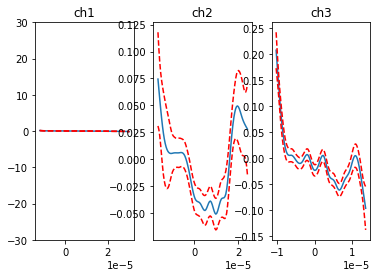

In [583]:
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['ch1', 'ch2', 'ch3']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

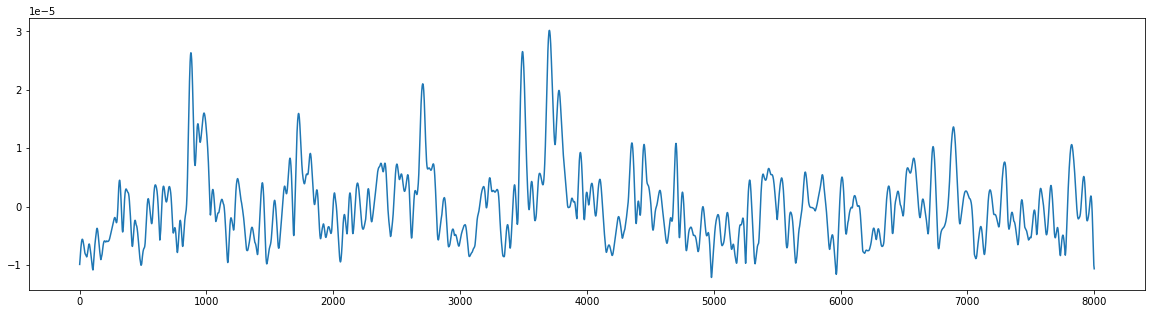

In [628]:
XX = gam.generate_X_grid(term=0, n=500)
plt.figure(figsize=(20,5))
# plt.plot(gam.predict(Tf_amp_1epoch), 'r--')
plt.plot(np.arange(8001),Tf_amp_1epoch.T[0])
# plt.plot(np.arange(3000), gam.predict(Tf_amp_1epoch)[:3000])
# plt.title('95% prediction interval');
# plt.scatter(X, y, facecolor='gray', edgecolors='none')
# plt.title('95% prediction interval');

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      s   No. Observations:                 8001
Model:                         GLMGam   Df Residuals:                     7990
Model Family:                Gaussian   Df Model:                        10.00
Link Function:               identity   Scale:                       0.0058726
Method:                         PIRLS   Log-Likelihood:                 9205.0
Date:                Wed, 26 Jan 2022   Deviance:                       46.922
Time:                        17:32:05   Pearson chi2:                     46.9
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0686      0.006     11.700      0.0

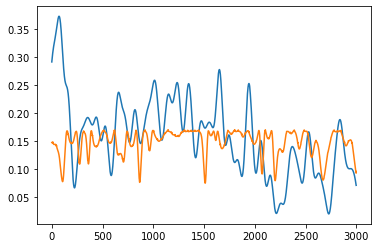

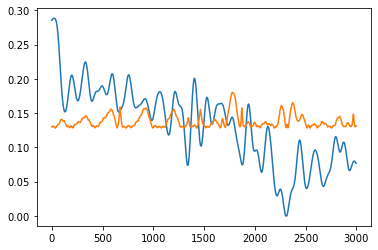

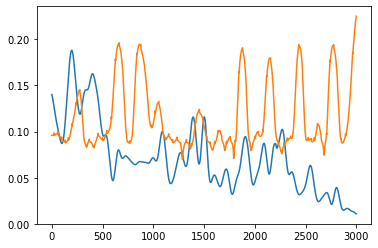

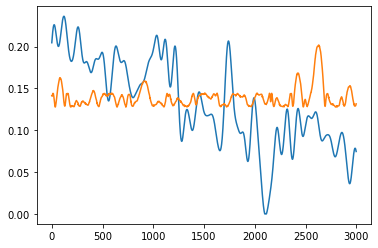

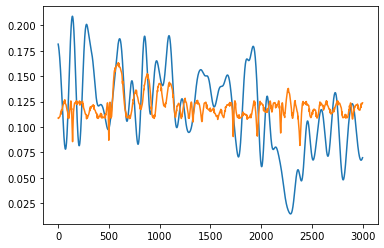

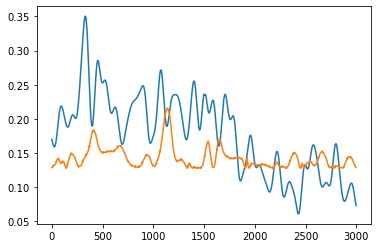

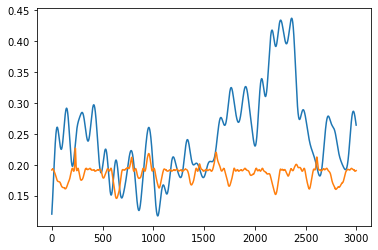

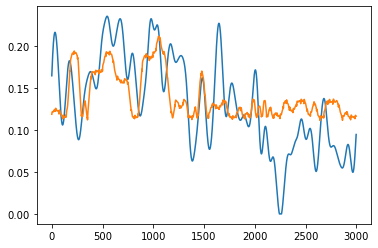

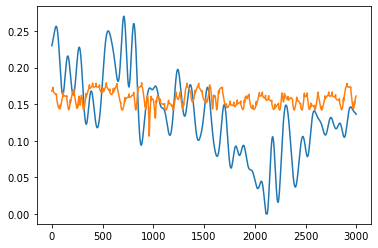

In [515]:
# 2-3: use GAM-spline to fit synergy amplitude, use AIC to find the best model r to quantify coherence

for n_epoch in range(Mf.shape[0]):
    synergies_1epoch = synergies[n_epoch]
    Mf_1epoch = Mf[n_epoch]
    analytic_signal = hilbert(Mf_1epoch[0])
    analytic_signal_s = hilbert(synergies_1epoch[0])
    amplitude_envelope_eeg = np.abs(analytic_signal)
    instantaneous_phase_eeg = np.angle(analytic_signal)  # from -2pi to 2pi
    instantaneous_frequency_eeg = (np.diff(np.unwrap(instantaneous_phase)) /
                           (2.0*np.pi) * fs)
    amplitude_envelope_s = np.abs(analytic_signal_s)
    instantaneous_phase_s = np.angle(analytic_signal_s)
    instantaneous_frequency_s = (np.diff(np.unwrap(instantaneous_phase)) /
                           (2.0*np.pi) * fs)
    # create dataframe
    df4gam = pd.DataFrame(np.vstack([amplitude_envelope_eeg, instantaneous_phase_eeg, amplitude_envelope_s, instantaneous_phase_s,synergies_1epoch[0]]).T, 
                          columns=['a_eeg', 'p_eeg', 'a_s', 'p_s', 's'])
    bs = BSplines(df4gam[['a_eeg', 'p_eeg']], df=[6,6], degree=[3,3])
    gam_bs = GLMGam.from_formula('s ~ a_eeg + p_eeg', data=df4gam, smoother=bs)
    res_bs = gam_bs.fit()
    print(res_bs.summary())
#     plt.figure()
#     res_bs.plot_partial(0)

    plt.figure()
#     sns.scatterplot(df4gam['a_s'], df4gam['a_eeg'])
    plt.plot(df4gam['s'][1000:4000].tolist())
    plt.plot(res_bs.predict()[1000:4000])
    print()

In [453]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# import data
from statsmodels.gam.tests.test_penalized import df_autos

# create spline basis for weight and hp
x_spline = df_autos[['weight', 'hp']]

bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])

# penalization weight
alpha = np.array([21833888.8, 6460.38479])
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos,
                               smoother=bs, alpha=alpha)


res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   189.13
Model Family:                Gaussian   Df Model:                        12.87
Link Function:               identity   Scale:                          4.8825
Method:                         PIRLS   Log-Likelihood:                -441.81
Date:                Wed, 26 Jan 2022   Deviance:                       923.45
Time:                        16:39:48   Pearson chi2:                     923.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.9923      1.997     26.034   

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   194.75
Model Family:                 Poisson   Df Model:                         7.25
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -530.38
Date:                Wed, 26 Jan 2022   Deviance:                       37.569
Time:                        16:39:49   Pearson chi2:                     37.4
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9960      0.130     30.844   

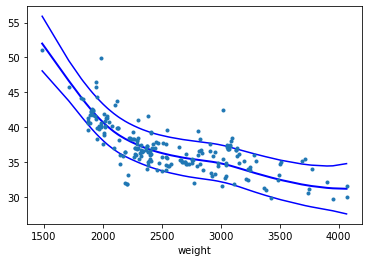

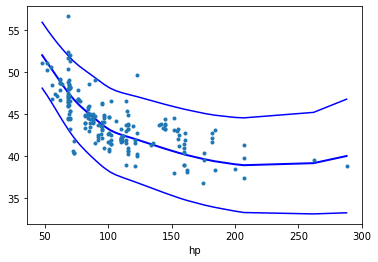

In [454]:
res_bs.plot_partial(0, cpr=True)

res_bs.plot_partial(1, cpr=True)


alpha = np.array([8283989284.5829611, 14628207.58927821])

gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos,
                                 smoother=bs, alpha=alpha,
                               family=sm.families.Poisson())
  

res_bs = gam_bs.fit()

print(res_bs.summary())

In [411]:
def _eval_bspline_basis(x, knots, degree, deriv='all', include_intercept=True):
    try:
        from scipy.interpolate import splev
    except ImportError:
        raise ImportError("spline functionality requires scipy")
    # 'knots' are assumed to be already pre-processed. E.g. usually you
    # want to include duplicate copies of boundary knots; you should do
    # that *before* calling this constructor.
    knots = np.atleast_1d(np.asarray(knots, dtype=float))
    assert knots.ndim == 1
    knots.sort()
    degree = int(degree)
    x = np.atleast_1d(x)
    if x.ndim == 2 and x.shape[1] == 1:
        x = x[:, 0]
    assert x.ndim == 1
    # XX FIXME: when points fall outside of the boundaries, splev and R seem
    # to handle them differently. I do not know why yet. So until we understand
    # this and decide what to do with it, I'm going to play it safe and
    # disallow such points.
    if np.min(x) < np.min(knots) or np.max(x) > np.max(knots):
        raise NotImplementedError("some data points fall outside the "
                                  "outermost knots, and I'm not sure how "
                                  "to handle them. (Patches accepted!)")
    # Thanks to Charles Harris for explaining splev. It's not well
    # documented, but basically it computes an arbitrary b-spline basis
    # given knots and degree on some specificed points (or derivatives
    # thereof, but we do not use that functionality), and then returns some
    # linear combination of these basis functions. To get out the basis
    # functions themselves, we use linear combinations like [1, 0, 0], [0,
    # 1, 0], [0, 0, 1].
    # NB: This probably makes it rather inefficient (though I have not checked
    # to be sure -- maybe the fortran code actually skips computing the basis
    # function for coefficients that are zero).
    # Note: the order of a spline is the same as its degree + 1.
    # Note: there are (len(knots) - order) basis functions.

    k_const = 1 - int(include_intercept)
    n_bases = len(knots) - (degree + 1) - k_const
    print(n_bases)
#     if deriv in ['all', 0]:
#         basis = np.empty((x.shape[0], n_bases), dtype=float)
#         ret = basis
#     if deriv in ['all', 1]:
#         der1_basis = np.empty((x.shape[0], n_bases), dtype=float)
#         ret = der1_basis
#     if deriv in ['all', 2]:
#         der2_basis = np.empty((x.shape[0], n_bases), dtype=float)
#         ret = der2_basis

    for i in range(n_bases):
        coefs = np.zeros((n_bases + k_const,))
        # we are skipping the first column of the basis to drop constant
        coefs[i + k_const] = 1
        ii = i
        if deriv in ['all', 0]:
            basis[:, ii] = splev(x, (knots, coefs, degree))
        if deriv in ['all', 1]:
            der1_basis[:, ii] = splev(x, (knots, coefs, degree), der=1)
        if deriv in ['all', 2]:
            der2_basis[:, ii] = splev(x, (knots, coefs, degree), der=2)

    if deriv == 'all':
        return basis, der1_basis, der2_basis
    else:
        return ret
_eval_bspline_basis(2.3, [0,1,2,3], 3)

0


NameError: name 'basis' is not defined

In [426]:
def get_knots_bsplines(x=None, df=None, knots=None, degree=3,
                       spacing='quantile', lower_bound=None,
                       upper_bound=None, all_knots=None):
    """knots for use in B-splines

    There are two main options for the knot placement

    - quantile spacing with multiplicity of boundary knots
    - equal spacing extended to boundary or exterior knots

    The first corresponds to splines as used by patsy. the second is the
    knot spacing for P-Splines.
    """
    # based on patsy memorize_finish
    if all_knots is not None:
        return all_knots

    x_min = x.min()
    x_max = x.max()

    if degree < 0:
        raise ValueError("degree must be greater than 0 (not %r)"
                         % (degree,))
    if int(degree) != degree:
        raise ValueError("degree must be an integer (not %r)"
                         % (degree,))

    # These are guaranteed to all be 1d vectors by the code above
    # x = np.concatenate(tmp["xs"])
    if df is None and knots is None:
        raise ValueError("must specify either df or knots")
    order = degree + 1
    if df is not None:
        n_inner_knots = df - order
        if n_inner_knots < 0:
            raise ValueError("df=%r is too small for degree=%r; must be >= %s"
                             % (df, degree,
                                # We know that n_inner_knots is negative;
                                # if df were that much larger, it would
                                # have been zero, and things would work.
                                df - n_inner_knots))
        if knots is not None:
            if len(knots) != n_inner_knots:
                raise ValueError("df=%s with degree=%r implies %s knots, "
                                 "but %s knots were provided"
                                 % (df, degree,
                                    n_inner_knots, len(knots)))
        elif spacing == 'quantile':
            # Need to compute inner knots
            knot_quantiles = np.linspace(0, 1, n_inner_knots + 2)[1:-1]
            inner_knots = _R_compat_quantile(x, knot_quantiles)
        elif spacing == 'equal':
            # Need to compute inner knots
            grid = np.linspace(0, 1, n_inner_knots + 2)[1:-1]
            inner_knots = x_min + grid * (x_max - x_min)
            diff_knots = inner_knots[1] - inner_knots[0]
        else:
            raise ValueError("incorrect option for spacing")
    if knots is not None:
        inner_knots = knots
    if lower_bound is None:
        lower_bound = np.min(x)
    if upper_bound is None:
        upper_bound = np.max(x)

    if lower_bound > upper_bound:
        raise ValueError("lower_bound > upper_bound (%r > %r)"
                         % (lower_bound, upper_bound))
    inner_knots = np.asarray(inner_knots)
    if inner_knots.ndim > 1:
        raise ValueError("knots must be 1 dimensional")
    if np.any(inner_knots < lower_bound):
        raise ValueError("some knot values (%s) fall below lower bound "
                         "(%r)"
                         % (inner_knots[inner_knots < lower_bound],
                            lower_bound))
    if np.any(inner_knots > upper_bound):
        raise ValueError("some knot values (%s) fall above upper bound "
                         "(%r)"
                         % (inner_knots[inner_knots > upper_bound],
                            upper_bound))

    if spacing == "equal":
        diffs = np.arange(1, order + 1) * diff_knots
        lower_knots = inner_knots[0] - diffs[::-1]
        upper_knots = inner_knots[-1] + diffs
        all_knots = np.concatenate((lower_knots, inner_knots, upper_knots))
    else:
        all_knots = np.concatenate(([lower_bound, upper_bound] * order,
                                    inner_knots))
    all_knots.sort()

    return all_knots

def _R_compat_quantile(x, probs):
    # return np.percentile(x, 100 * np.asarray(probs))
    probs = np.asarray(probs)
    quantiles = np.asarray([np.percentile(x, 100 * prob)
                            for prob in probs.ravel(order="C")])
    return quantiles.reshape(probs.shape, order="C")

get_knots_bsplines(x_spline['weight'], degree=3, df=12).shape

AttributeError: 'NoneType' object has no attribute 'sort'